In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt
import hvplot.pandas

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc
)
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

In [3]:
data = pd.read_csv("lending_club_loan_two.csv")
data.head()

loan_amnt        term  int_rate  installment grade sub_grade  \
0   10000.00   36 months     11.44       329.48     B        B4   
1    8000.00   36 months     11.99       265.68     B        B5   
2   15600.00   36 months     10.49       506.97     B        B3   
3    7200.00   36 months      6.49       220.65     A        A2   
4   24375.00   60 months     17.27       609.33     C        C5   

                 emp_title emp_length home_ownership  annual_inc  \
0                Marketing  10+ years           RENT   117000.00   
1          Credit analyst     4 years       MORTGAGE    65000.00   
2             Statistician   < 1 year           RENT    43057.00   
3          Client Advocate    6 years           RENT    54000.00   
4  Destiny Management Inc.    9 years       MORTGAGE    55000.00   

  verification_status   issue_d  loan_status             purpose  \
0        Not Verified  Jan-2015   Fully Paid            vacation   
1        Not Verified  Jan-2015   Fully Paid  debt_consolidation   
2     Source Verified  Jan-2015   Fully Paid         credit_card   
3        Not Verified  Nov-2014   Fully Paid         credit_card   
4            Verified  Apr-2013  Charged Off         credit_card   

                     title   dti earliest_cr_line  open_acc  pub_rec  \
0                 Vacation 26.24         Jun-1990     16.00     0.00   
1       Debt consolidation 22.05         Jul-2004     17.00     0.00   
2  Credit card refinancing 12.79         Aug-2007     13.00     0.00   
3  Credit card refinancing  2.60         Sep-2006      6.00     0.00   
4    Credit Card Refinance 33.95         Mar-1999     13.00     0.00   

   revol_bal  revol_util  total_acc initial_list_status application_type  \
0   36369.00       41.80      25.00                   w       INDIVIDUAL   
1   20131.00       53.30      27.00                   f       INDIVIDUAL   
2   11987.00       92.20      26.00                   f       INDIVIDUAL   
3    5472.00       21.50      13.00                   f       INDIVIDUAL   
4   24584.00       69.80      43.00                   f       INDIVIDUAL   

   mort_acc  pub_rec_bankruptcies  \
0      0.00                  0.00   
1      3.00                  0.00   
2      0.00                  0.00   
3      0.00                  0.00   
4      1.00                  0.00   

                                             address  
0     0174 Michelle Gateway\r\nMendozaberg, OK 22690  
1  1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113  
2  87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113  
3            823 Reid Ford\r\nDelacruzside, MA 00813  
4             679 Luna Roads\r\nGreggshire, VA 11650

In [4]:
data.describe()

loan_amnt  int_rate  installment  annual_inc       dti  open_acc  \
count  396030.00 396030.00    396030.00   396030.00 396030.00 396030.00   
mean    14113.89     13.64       431.85    74203.18     17.38     11.31   
std      8357.44      4.47       250.73    61637.62     18.02      5.14   
min       500.00      5.32        16.08        0.00      0.00      0.00   
25%      8000.00     10.49       250.33    45000.00     11.28      8.00   
50%     12000.00     13.33       375.43    64000.00     16.91     10.00   
75%     20000.00     16.49       567.30    90000.00     22.98     14.00   
max     40000.00     30.99      1533.81  8706582.00   9999.00     90.00   

        pub_rec  revol_bal  revol_util  total_acc  mort_acc  \
count 396030.00  396030.00   395754.00  396030.00 358235.00   
mean       0.18   15844.54       53.79      25.41      1.81   
std        0.53   20591.84       24.45      11.89      2.15   
min        0.00       0.00        0.00       2.00      0.00   
25%        0.00    6025.00       35.80      17.00      0.00   
50%        0.00   11181.00       54.80      24.00      1.00   
75%        0.00   19620.00       72.90      32.00      3.00   
max       86.00 1743266.00      892.30     151.00     34.00   

       pub_rec_bankruptcies  
count             395495.00  
mean                   0.12  
std                    0.36  
min                    0.00  
25%                    0.00  
50%                    0.00  
75%                    0.00  
max                    8.00

In [5]:
data['issue_d']

0         Jan-2015
1         Jan-2015
2         Jan-2015
3         Nov-2014
4         Apr-2013
            ...   
396025    Oct-2015
396026    Feb-2015
396027    Oct-2013
396028    Aug-2012
396029    Jun-2010
Name: issue_d, Length: 396030, dtype: object

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394274 non-null  object 
 15  

## ✔️ `loan_status`

> Current status of the loan

In [9]:
data['loan_status'].value_counts().hvplot.bar(
    title="Loan Status Counts", xlabel='Loan Status', ylabel='Count', 
    width=500, height=350
)

:Bars   [loan_status]   (count)

<Axes: >

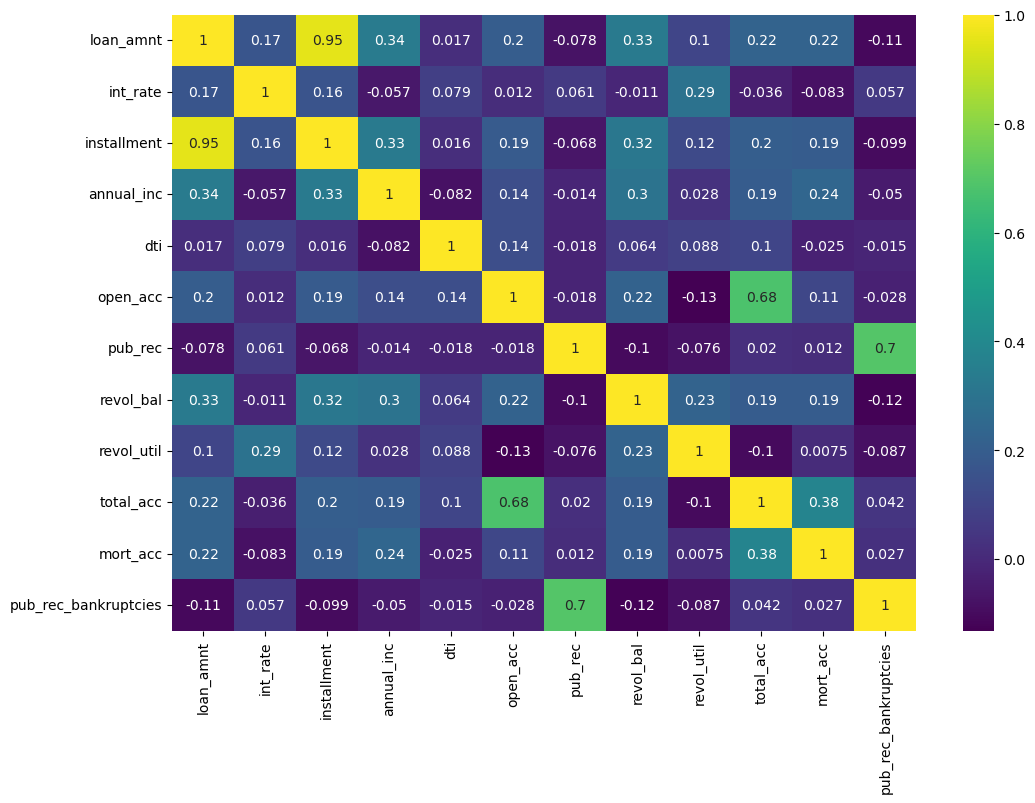

In [10]:
numeric_data = data.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 8))
sns.heatmap(numeric_data.corr(), annot=True, cmap='viridis')


## ✔️ `loan_amnt` & `installment`

> - `installment`: The monthly payment owed by the borrower if the loan originates.
> - `loan_amnt`: The listed amount of the loan applied for by the borrower. If at some point in time, the credit department reduces the loan amount, then it will be reflected in this value.

In [13]:
installment = data.hvplot.hist(
    y='installment', by='loan_status', subplots=False, 
    width=350, height=400, bins=50, alpha=0.4, 
    title="Installment by Loan Status", 
    xlabel='Installment', ylabel='Counts', legend='top'
)

loan_amnt = data.hvplot.hist(
    y='loan_amnt', by='loan_status', subplots=False, 
    width=350, height=400, bins=30, alpha=0.4, 
    title="Loan Amount by Loan Status", 
    xlabel='Loan Amount', ylabel='Counts', legend='top'
)

installment + loan_amnt

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [installment]   (Count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [loan_amnt]   (Count)

In [14]:
loan_amnt_box = data.hvplot.box(
    y='loan_amnt', subplots=True, by='loan_status', width=300, height=350, 
    title="Loan Status by Loan Amount ", xlabel='Loan Status', ylabel='Loan Amount'
)

installment_box = data.hvplot.box(
    y='installment', subplots=True, by='loan_status', width=300, height=350, 
    title="Loan Status by Installment", xlabel='Loan Status', ylabel='Installment'
)

loan_amnt_box + installment_box

:Layout
   .BoxWhisker.I  :BoxWhisker   [loan_status]   (loan_amnt)
   .BoxWhisker.II :BoxWhisker   [loan_status]   (installment)

In [15]:
data.groupby(by='loan_status')['loan_amnt'].describe()

count     mean     std     min     25%      50%      75%  \
loan_status                                                                
Charged Off  77673.00 15126.30 8505.09 1000.00 8525.00 14000.00 20000.00   
Fully Paid  318357.00 13866.88 8302.32  500.00 7500.00 12000.00 19225.00   

                 max  
loan_status           
Charged Off 40000.00  
Fully Paid  40000.00

## ✔️ `grade` & `sub_grade`

> - `grade`: LC assigned loan grade
> - `sub_grade`: LC assigned loan subgrade

Let's explore the Grade and SubGrade columns that LendingClub attributes to the loans. 

What are the unique possible `grade` & `sub_grade`?

In [17]:
print(f"GRADE unique: {data.grade.unique()}")
print(f"SUB_GRADE unique: {data.sub_grade.unique()}")

GRADE unique: ['B' 'A' 'C' 'E' 'D' 'F' 'G']
SUB_GRADE unique: ['B4' 'B5' 'B3' 'A2' 'C5' 'C3' 'A1' 'B2' 'C1' 'A5' 'E4' 'A4' 'A3' 'D1'
 'C2' 'B1' 'D3' 'D5' 'D2' 'E1' 'E2' 'E5' 'F4' 'E3' 'D4' 'G1' 'F5' 'G2'
 'C4' 'F1' 'F3' 'G5' 'G4' 'F2' 'G3']


In [19]:
fully_paid = data.loc[data['loan_status']=='Fully Paid', 'grade'].value_counts().hvplot.bar() 
charged_off = data.loc[data['loan_status']=='Charged Off', 'grade'].value_counts().hvplot.bar() 

(fully_paid * charged_off).opts(
    title="Loan Status by Grade", xlabel='Grades', ylabel='Count',
    width=500, height=450, legend_cols=2, legend_position='top_right', xrotation=90
)

:Overlay
   .Bars.Count.I  :Bars   [grade]   (count)
   .Bars.Count.II :Bars   [grade]   (count)

In [20]:
fully_paid = data.loc[data['loan_status']=='Fully Paid', 'sub_grade'].value_counts().hvplot.bar() 
charged_off = data.loc[data['loan_status']=='Charged Off', 'sub_grade'].value_counts().hvplot.bar() 

(fully_paid * charged_off).opts(
    title="Loan Status by Grade", xlabel='Grades', ylabel='Count',
    width=500, height=400, legend_cols=2, legend_position='top_right', xrotation=90
)

:Overlay
   .Bars.Count.I  :Bars   [sub_grade]   (count)
   .Bars.Count.II :Bars   [sub_grade]   (count)

In [21]:
# data.hvplot.bar()

C:\Users\bghsi\AppData\Local\Temp\ipykernel_24156\121092049.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90);


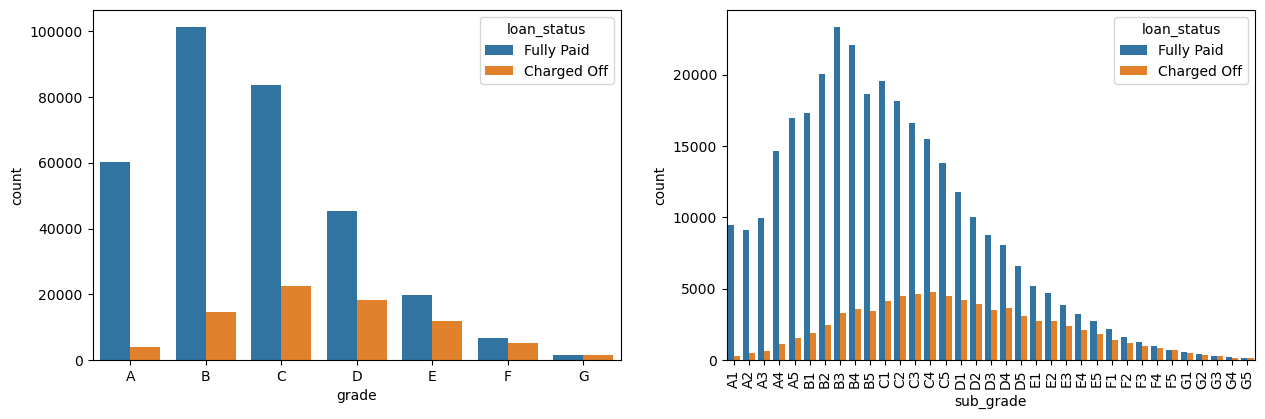

In [22]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
grade = sorted(data.grade.unique().tolist())
sns.countplot(x='grade', data=data, hue='loan_status', order=grade)

plt.subplot(2, 2, 2)
sub_grade = sorted(data.sub_grade.unique().tolist())
g = sns.countplot(x='sub_grade', data=data, hue='loan_status', order=sub_grade)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

It looks like `F` and `G` subgrades don't get paid back that often. Isloate those and recreate the countplot just for those subgrades.

<Axes: xlabel='sub_grade', ylabel='count'>

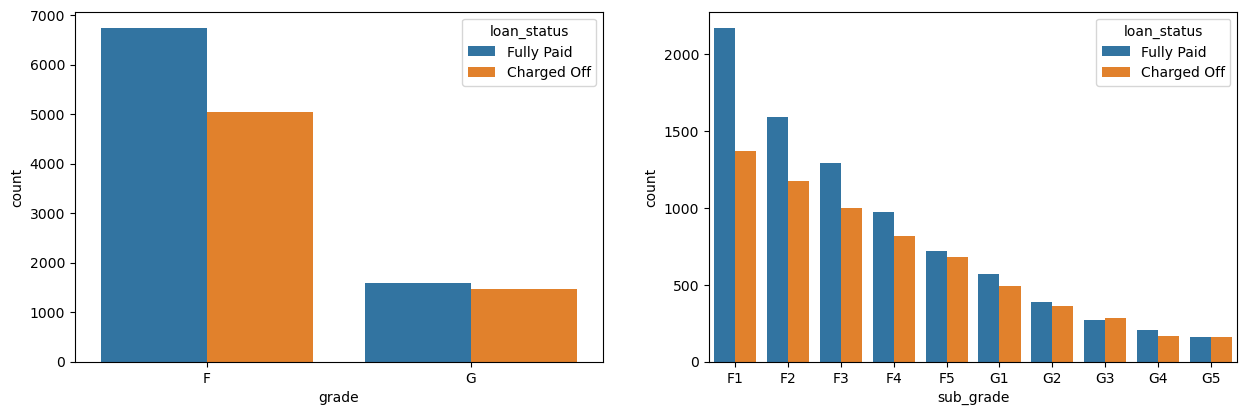

In [24]:
df = data[(data.grade == 'F') | (data.grade == 'G')]

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
grade = sorted(df.grade.unique().tolist())
sns.countplot(x='grade', data=df, hue='loan_status', order=grade)

plt.subplot(2, 2, 2)
sub_grade = sorted(df.sub_grade.unique().tolist())
sns.countplot(x='sub_grade', data=df, hue='loan_status', order=sub_grade)

## ✔️ `term`, `home_ownership`, `verification_status` & `purpose`

> - `term`: The number of payments on the loan. Values are in months and can be either 36 or 60.
> - `home_ownership`: The home ownership status provided by the borrower during registration or obtained from the credit report. Our values are: RENT, OWN, MORTGAGE, OTHER
> - `verification_status`: Indicates if income was verified by LC, not verified, or if the income source was verified
> - `purpose`: A category provided by the borrower for the loan request.

In [26]:
data['home_ownership'].value_counts()

home_ownership
MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: count, dtype: int64

In [27]:
fully_paid = data.loc[data['loan_status']=='Fully Paid', 'home_ownership'].value_counts().hvplot.bar() 
charged_off = data.loc[data['loan_status']=='Charged Off', 'home_ownership'].value_counts().hvplot.bar()

home_ownership_count = (fully_paid * charged_off).opts(
    title="Loan Status by Grade", xlabel='Home Ownership', ylabel='Count',
    width=350, height=350, legend_cols=2, legend_position='top_right'
).opts(xrotation=90)

home_ownership = data.home_ownership.value_counts().hvplot.bar(
    title="Loan Status by Grade", xlabel='Home Ownership', ylabel='Count', 
    width=350, height=350, legend='top'
).opts(xrotation=90)

(home_ownership_count + home_ownership)

:Layout
   .Overlay.Count :Overlay
      .Bars.Count.I  :Bars   [home_ownership]   (count)
      .Bars.Count.II :Bars   [home_ownership]   (count)
   .Bars.Count    :Bars   [home_ownership]   (count)

In [28]:
data.loc[(data.home_ownership == 'ANY') | (data.home_ownership == 'NONE'), 'home_ownership'] = 'OTHER'  
data.home_ownership.value_counts()

home_ownership
MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          146
Name: count, dtype: int64

C:\Users\bghsi\AppData\Local\Temp\ipykernel_24156\2424757870.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90);


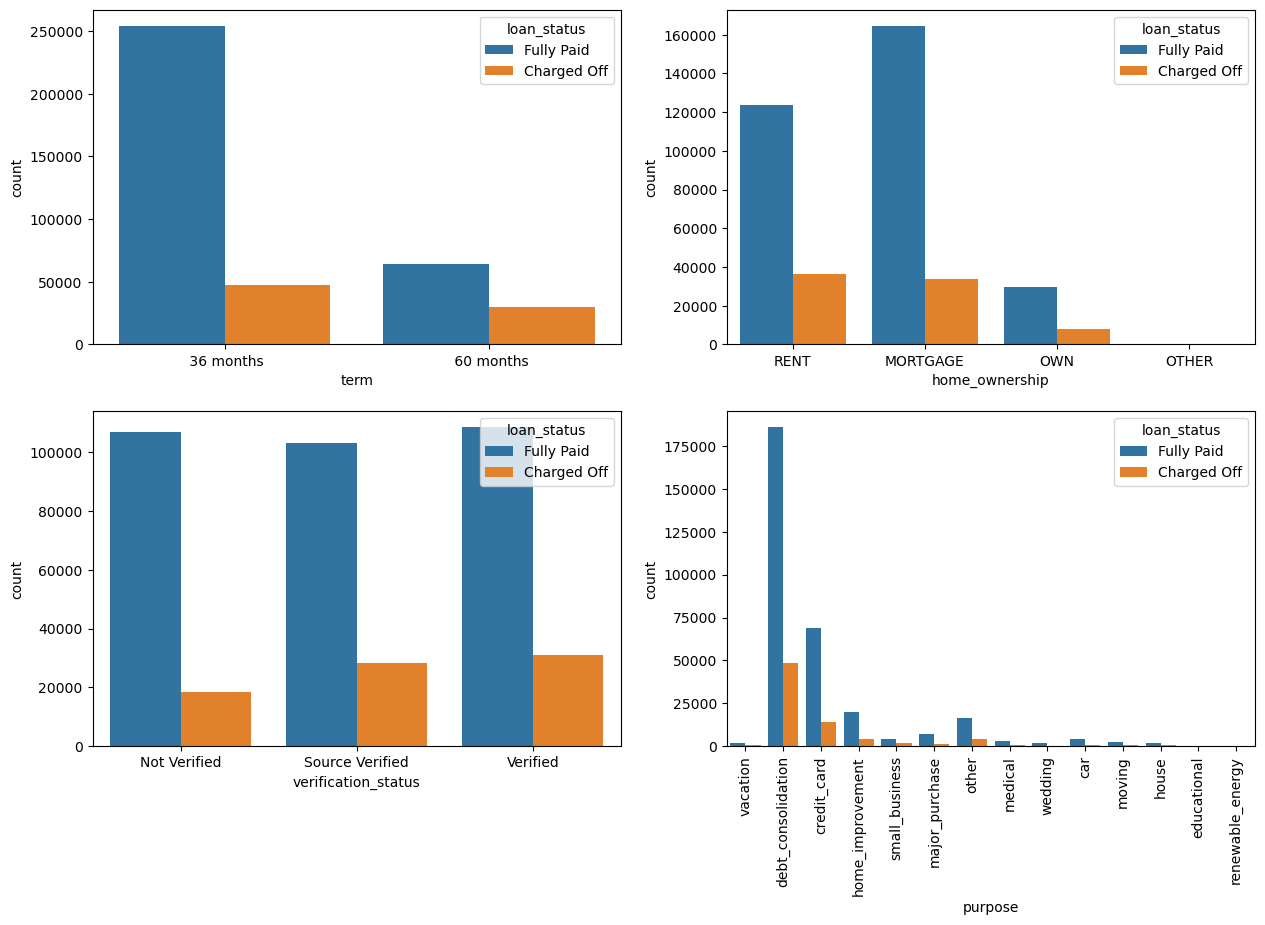

In [29]:
plt.figure(figsize=(15, 20))

plt.subplot(4, 2, 1)
sns.countplot(x='term', data=data, hue='loan_status')

plt.subplot(4, 2, 2)
sns.countplot(x='home_ownership', data=data, hue='loan_status')

plt.subplot(4, 2, 3)
sns.countplot(x='verification_status', data=data, hue='loan_status')

plt.subplot(4, 2, 4)
g = sns.countplot(x='purpose', data=data, hue='loan_status')
g.set_xticklabels(g.get_xticklabels(), rotation=90);

In [30]:
data.loc[data['home_ownership']=='OTHER', 'loan_status'].value_counts()

loan_status
Fully Paid     123
Charged Off     23
Name: count, dtype: int64

## ✔️ `int_rate` & `annual_inc`

> - `int_rate`: Interest Rate on the loan
> - `annual_inc`: The self-reported annual income provided by the borrower during registration

In [32]:
int_rate = data.hvplot.hist(
    y='int_rate', by='loan_status', alpha=0.3, width=350, height=400,
    title="Loan Status by Interest Rate", xlabel='Interest Rate', ylabel='Loans Counts', 
    legend='top'
)

annual_inc = data.hvplot.hist(
    y='annual_inc', by='loan_status', bins=50, alpha=0.3, width=350, height=400,
    title="Loan Status by Annual Income", xlabel='Annual Income', ylabel='Loans Counts', 
    legend='top'
).opts(xrotation=45)

int_rate + annual_inc

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [int_rate]   (Count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [annual_inc]   (Count)

In [33]:
data[data.annual_inc <= 250000].hvplot.hist(
    y='annual_inc', by='loan_status', bins=50, alpha=0.3, width=500, height=400,
    title="Loan Status by Annual Income (<= 250000/Year)", 
    xlabel='Annual Income', ylabel='Loans Counts', legend='top'
).opts(xrotation=45)

:NdOverlay   [loan_status]
   :Histogram   [annual_inc]   (Count)

In [34]:
print((data[data.annual_inc >= 250000].shape[0] / data.shape[0]) * 100)
print((data[data.annual_inc >= 1000000].shape[0] / data.shape[0]) * 100)

1.0294674645860162
0.018937959245511705


In [35]:
data.loc[data.annual_inc >= 1000000, 'loan_status'].value_counts()

loan_status
Fully Paid     65
Charged Off    10
Name: count, dtype: int64

In [36]:
data.loc[data.annual_inc >= 250000, 'loan_status'].value_counts()

loan_status
Fully Paid     3509
Charged Off     568
Name: count, dtype: int64

- It seems that loans with high intersest rate are more likely to be unpaid.
- Only 75 (less then) borrowers have an annual income more than 1 million, and 4077

## ✔️ `emp_title` & `emp_length`

> - `emp_title`: The job title supplied by the Borrower when applying for the loan.
> - `emp_length`: Employment length in years. Possible values are between 0 and 10 where 0 means less than one year and 10 means ten or more years.

In [39]:
print(data.emp_title.isna().sum())
print(data.emp_title.nunique())

22927
173105


In [40]:
data['emp_title'].value_counts()[:20]

emp_title
Teacher                     4389
Manager                     4250
Registered Nurse            1856
RN                          1846
Supervisor                  1830
Sales                       1638
Project Manager             1505
Owner                       1410
Driver                      1339
Office Manager              1218
manager                     1145
Director                    1089
General Manager             1074
Engineer                     995
teacher                      962
driver                       882
Vice President               857
Operations Manager           763
Administrative Assistant     756
Accountant                   748
Name: count, dtype: int64

C:\Users\bghsi\AppData\Local\Temp\ipykernel_24156\1777488078.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xticklabels(), rotation=90);


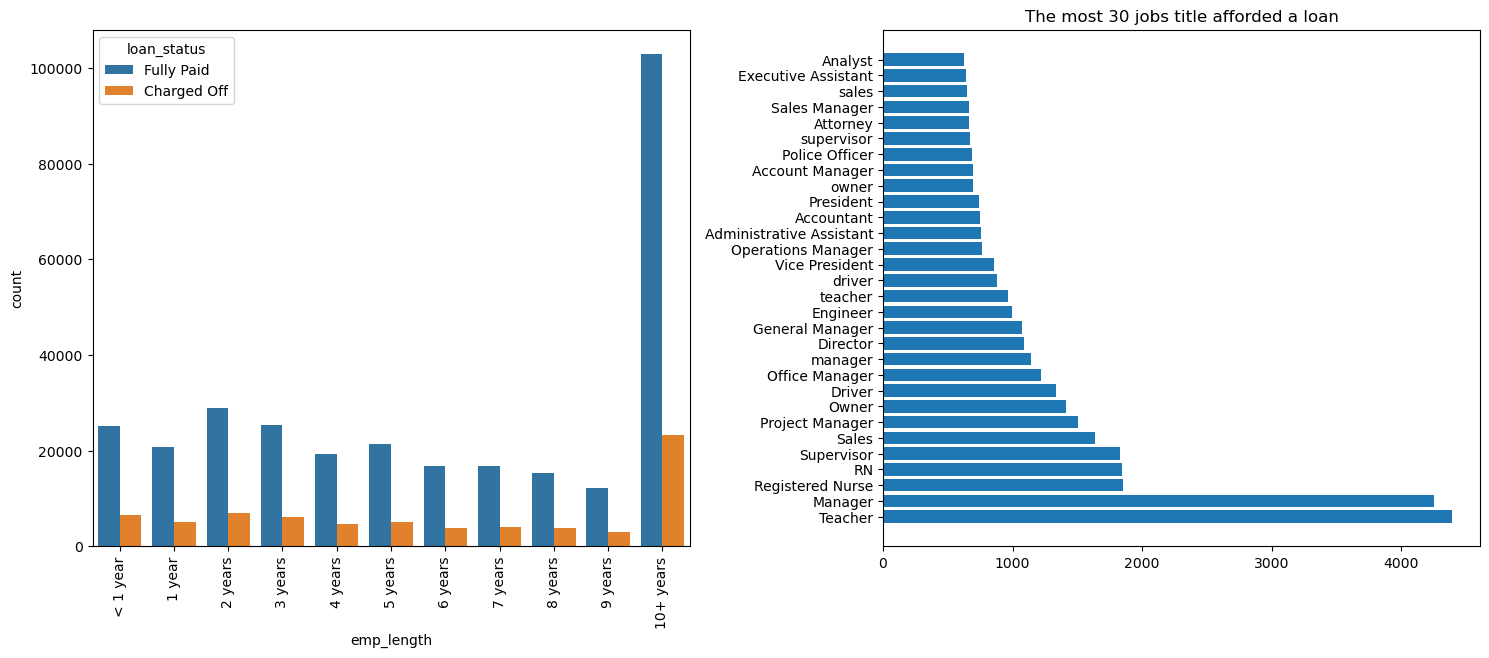

In [41]:
plt.figure(figsize=(15, 12))

plt.subplot(2, 2, 1)
order = ['< 1 year', '1 year', '2 years', '3 years', '4 years', '5 years', 
          '6 years', '7 years', '8 years', '9 years', '10+ years',]
g = sns.countplot(x='emp_length', data=data, hue='loan_status', order=order)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

plt.subplot(2, 2, 2)
plt.barh(data.emp_title.value_counts()[:30].index, data.emp_title.value_counts()[:30])
plt.title("The most 30 jobs title afforded a loan")
plt.tight_layout()

## ✔️ `issue_d`, `earliest_cr_line`

> - `issue_d`: The month which the loan was funded
> - `earliest_cr_line`: The month the borrower's earliest reported credit line was opened

In [43]:
# data.hvplot.line(x='issue_d', y='loan_status')

In [44]:
data['earliest_cr_line'].value_counts()

earliest_cr_line
Oct-2000    3017
Aug-2000    2935
Oct-2001    2896
Aug-2001    2884
Nov-2000    2736
            ... 
Jul-1958       1
Nov-1957       1
Jan-1953       1
Jul-1955       1
Aug-1959       1
Name: count, Length: 684, dtype: int64

In [45]:
data['issue_d'] = pd.to_datetime(data['issue_d'])
data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])

C:\Users\bghsi\AppData\Local\Temp\ipykernel_24156\836848778.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['issue_d'] = pd.to_datetime(data['issue_d'])
C:\Users\bghsi\AppData\Local\Temp\ipykernel_24156\836848778.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['earliest_cr_line'] = pd.to_datetime(data['earliest_cr_line'])


In [46]:
fully_paid = data.loc[data['loan_status']=='Fully Paid', 'issue_d'].hvplot.hist(bins=35) 
charged_off = data.loc[data['loan_status']=='Charged Off', 'issue_d'].hvplot.hist(bins=35)

# fully_paid * charged_off
loan_issue_date = (fully_paid * charged_off).opts(
    title="Loan Status by Loan Issue Date", xlabel='Loan Issue Date', ylabel='Count',
    width=350, height=350, legend_cols=2, legend_position='top_right'
).opts(xrotation=45)

fully_paid = data.loc[data['loan_status']=='Fully Paid', 'earliest_cr_line'].hvplot.hist(bins=35) 
charged_off = data.loc[data['loan_status']=='Charged Off', 'earliest_cr_line'].hvplot.hist(bins=35)

earliest_cr_line = (fully_paid * charged_off).opts(
    title="Loan Status by earliest_cr_line", xlabel='earliest_cr_line', ylabel='Count',
    width=350, height=350, legend_cols=2, legend_position='top_right'
).opts(xrotation=45)

loan_issue_date + earliest_cr_line

:Layout
   .Overlay.I  :Overlay
      .Histogram.I  :Histogram   [issue_d]   (Count)
      .Histogram.II :Histogram   [issue_d]   (Count)
   .Overlay.II :Overlay
      .Histogram.I  :Histogram   [earliest_cr_line]   (Count)
      .Histogram.II :Histogram   [earliest_cr_line]   (Count)

## ✔️ `title`

> - `title`: The loan title provided by the borrower

In [48]:
data.title.isna().sum()

1756

In [49]:
data['title'] = data.title.str.lower()

In [50]:
data.title.value_counts()[:10]

title
debt consolidation           168108
credit card refinancing       51781
home improvement              17117
other                         12993
consolidation                  5583
major purchase                 4998
debt consolidation loan        3513
business                       3017
medical expenses               2820
credit card consolidation      2638
Name: count, dtype: int64

`title` will be removed because we have the `purpose` column with is generated from it.

## ✔️ `dti`, `open_acc`, `revol_bal`, `revol_util`, & `total_acc`

> - `dti`: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income.
> - `open_acc`: The number of open credit lines in the borrower's credit file.
> - `revol_bal`: Total credit revolving balance
> - `revol_util`: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit.
> - `total_acc`: The total number of credit lines currently in the borrower's credit file

In [53]:
data.dti.value_counts()

dti
0.00     313
14.40    310
19.20    302
16.80    301
18.00    300
        ... 
59.18      1
48.37      1
45.71      1
42.38      1
55.53      1
Name: count, Length: 4262, dtype: int64

In [54]:
dti = data.hvplot.hist(
    y='dti', bins=50, width=350, height=350, 
    title="dti Distribution", xlabel='dti', ylabel='Count'
)

sub_dti = data[data['dti']<=50].hvplot.hist(
    y='dti', bins=50, width=350, height=350, 
    title="dti (<=30) Distribution", xlabel='dti', ylabel='Count', shared_axes=False
)

dti + sub_dti

:Layout
   .Histogram.I  :Histogram   [dti]   (Count)
   .Histogram.II :Histogram   [dti]   (Count)

In [55]:
print(data[data['dti']>=40].shape)

(296, 27)


In [56]:
data.loc[data['dti']>=50, 'loan_status'].value_counts()

loan_status
Fully Paid     26
Charged Off     9
Name: count, dtype: int64

In [57]:
dti = data[data['dti']<=50].hvplot.hist(
    y='dti', by='loan_status', bins=50, width=300, height=350, 
    title="dti (<=30) Distribution", xlabel='dti', ylabel='Count', 
    alpha=0.3, legend='top'
)

title="Loan Status by The number of open credit lines"

open_acc = data.hvplot.hist(
    y='open_acc', by='loan_status', bins=50, width=300, height=350, 
    title=title, xlabel='The number of open credit lines', ylabel='Count', 
    alpha=0.4, legend='top'
)

title="Loan Status by The total number of credit lines"

total_acc = data.hvplot.hist(
    y='total_acc', by='loan_status', bins=50, width=300, height=350, 
    title=title, xlabel='The total number of credit lines', ylabel='Count', 
    alpha=0.4, legend='top'
)

dti + open_acc + total_acc

:Layout
   .NdOverlay.I   :NdOverlay   [loan_status]
      :Histogram   [dti]   (Count)
   .NdOverlay.II  :NdOverlay   [loan_status]
      :Histogram   [open_acc]   (Count)
   .NdOverlay.III :NdOverlay   [loan_status]
      :Histogram   [total_acc]   (Count)

In [58]:
print(data.shape)
print(data[data.open_acc > 40].shape)

(396030, 27)
(217, 27)


In [59]:
print(data.shape)
print(data[data.total_acc > 80].shape)

(396030, 27)
(266, 27)


In [60]:
print(data.shape)
print(data[data.revol_util > 120].shape)

(396030, 27)
(27, 27)


In [61]:
title="Loan Status by Revolving line utilization rate"

revol_util = data.hvplot.hist(
    y='revol_util', by='loan_status', bins=50, width=350, height=400, 
    title=title, xlabel='Revolving line utilization rate', ylabel='Count', 
    alpha=0.4, legend='top'
)

title="Loan Status by Revolving line utilization rate (<120)"

sub_revol_util = data[data.revol_util < 120].hvplot.hist(
    y='revol_util', by='loan_status', bins=50, width=350, height=400, 
    title=title, xlabel='Revolving line utilization rate', ylabel='Count', 
    shared_axes=False, alpha=0.4, legend='top'
)

revol_util + sub_revol_util

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [revol_util]   (Count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [revol_util]   (Count)

In [62]:
data[data.revol_util > 200]

loan_amnt        term  int_rate  installment grade sub_grade  \
137211    3500.00   36 months     12.49       117.08     B        B4   

             emp_title emp_length home_ownership  annual_inc  \
137211  Budget Analyst  10+ years           RENT    45000.00   

       verification_status    issue_d loan_status             purpose  \
137211            Verified 2014-04-01  Fully Paid  debt_consolidation   

                     title   dti earliest_cr_line  open_acc  pub_rec  \
137211  debt consolidation 14.67       1998-10-01      2.00     0.00   

        revol_bal  revol_util  total_acc initial_list_status application_type  \
137211    2677.00      892.30       9.00                   f       INDIVIDUAL   

        mort_acc  pub_rec_bankruptcies  \
137211      0.00                  0.00   

                                             address  
137211  12506 Connie Burg\r\nVelasquezfort, TN 00813

In [63]:
print(data.shape)
print(data[data.revol_bal > 250000].shape)

(396030, 27)
(397, 27)


In [64]:
title = "Loan Status by Total credit revolving balance"

revol_bal = data.hvplot.hist(
    y='revol_bal', by='loan_status', bins=50, width=350, height=400, 
    title=title, xlabel='Total credit revolving balance', ylabel='Count', 
    alpha=0.4, legend='top'
)

title = "Loan Status by Total credit revolving balance (<250000)"

sub_revol_bal = data[data['revol_bal']<=250000].hvplot.hist(
    y='revol_bal', by='loan_status', bins=50, width=350, height=400, 
    title=title, xlabel='Total credit revolving balance', ylabel='Count', 
    alpha=0.4, legend='top', shared_axes=False
).opts(xrotation=45)

revol_bal + sub_revol_bal

:Layout
   .NdOverlay.I  :NdOverlay   [loan_status]
      :Histogram   [revol_bal]   (Count)
   .NdOverlay.II :NdOverlay   [loan_status]
      :Histogram   [revol_bal]   (Count)

In [65]:
data.loc[data.revol_bal > 250000, 'loan_status'].value_counts()

loan_status
Fully Paid     351
Charged Off     46
Name: count, dtype: int64

## ✔️ `pub_rec`, `initial_list_status`, `application_type`, `mort_acc`, & `pub_rec_bankruptcies`

> - `pub_rec`: Number of derogatory public records
> - `initial_list_status`: The initial listing status of the loan. Possible values are – W, F
> - `application_type`: Indicates whether the loan is an individual application or a joint application with two co-borrowers
> - `mort_acc`: Number of mortgage accounts
> - `pub_rec_bankruptcies`: Number of public record bankruptcies

In [68]:
xlabel = 'Number of derogatory public records'
title = "Loan Status by Number of derogatory public records"

fully_paid = data.loc[data['loan_status']=='Fully Paid', 'pub_rec'].value_counts().hvplot.bar() 
charged_off = data.loc[data['loan_status']=='Charged Off', 'pub_rec'].value_counts().hvplot.bar()

(fully_paid * charged_off).opts(
    title=title, xlabel=xlabel, ylabel='Count',
    width=400, height=400, legend_cols=2, legend_position='top_right'
)

:Overlay
   .Bars.Count.I  :Bars   [pub_rec]   (count)
   .Bars.Count.II :Bars   [pub_rec]   (count)

In [69]:
xlabel = "The initial listing status of the loan"
title = "Loan Status by The initial listing status of the loan"

fully_paid = data.loc[data['loan_status']=='Fully Paid', 'initial_list_status'].value_counts().hvplot.bar() 
charged_off = data.loc[data['loan_status']=='Charged Off', 'initial_list_status'].value_counts().hvplot.bar()

(fully_paid * charged_off).opts(
    title=title, xlabel=xlabel, ylabel='Count',
    width=400, height=400, legend_cols=2, legend_position='top_right'
)

:Overlay
   .Bars.Count.I  :Bars   [initial_list_status]   (count)
   .Bars.Count.II :Bars   [initial_list_status]   (count)

In [70]:
fully_paid = data.loc[data['loan_status']=='Fully Paid', 'application_type'].value_counts().hvplot.bar() 
charged_off = data.loc[data['loan_status']=='Charged Off', 'application_type'].value_counts().hvplot.bar()

(fully_paid * charged_off).opts(
    title="Loan Status by Application Type", xlabel="Application Type", ylabel='Count',
    width=400, height=400, legend_cols=2, legend_position='top_right'
)

:Overlay
   .Bars.Count.I  :Bars   [application_type]   (count)
   .Bars.Count.II :Bars   [application_type]   (count)

In [71]:
xlabel = "Number of public record bankruptcies"
title = "Loan Status by The Number of public record bankruptcies"

fully_paid = data.loc[data['loan_status']=='Fully Paid', 'pub_rec_bankruptcies'].value_counts().hvplot.bar() 
charged_off = data.loc[data['loan_status']=='Charged Off', 'pub_rec_bankruptcies'].value_counts().hvplot.bar()

(fully_paid * charged_off).opts(
    title=title, xlabel=xlabel, ylabel='Count',
    width=400, height=400, legend_cols=2, legend_position='top_right'
)

:Overlay
   .Bars.Count.I  :Bars   [pub_rec_bankruptcies]   (count)
   .Bars.Count.II :Bars   [pub_rec_bankruptcies]   (count)

In [72]:
def pub_rec(number):
    if number == 0.0:
        return 0
    else:
        return 1
    
def mort_acc(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number
    
def pub_rec_bankruptcies(number):
    if number == 0.0:
        return 0
    elif number >= 1.0:
        return 1
    else:
        return number

In [73]:
data['pub_rec'] = data.pub_rec.apply(pub_rec)
data['mort_acc'] = data.mort_acc.apply(mort_acc)
data['pub_rec_bankruptcies'] = data.pub_rec_bankruptcies.apply(pub_rec_bankruptcies)

<Axes: xlabel='pub_rec_bankruptcies', ylabel='count'>

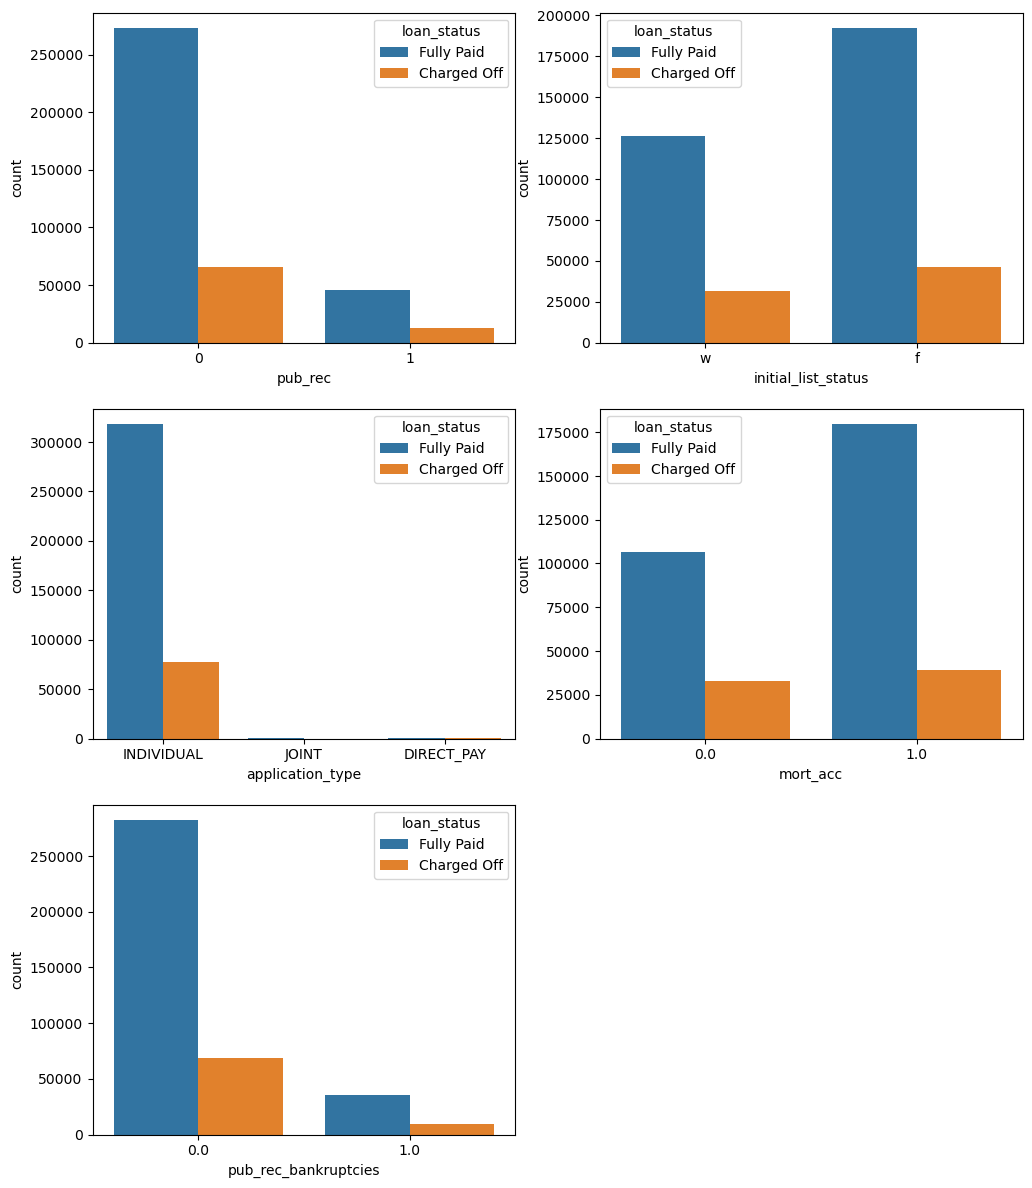

In [74]:
plt.figure(figsize=(12, 30))

plt.subplot(6, 2, 1)
sns.countplot(x='pub_rec', data=data, hue='loan_status')

plt.subplot(6, 2, 2)
sns.countplot(x='initial_list_status', data=data, hue='loan_status')

plt.subplot(6, 2, 3)
sns.countplot(x='application_type', data=data, hue='loan_status')

plt.subplot(6, 2, 4)
sns.countplot(x='mort_acc', data=data, hue='loan_status')

plt.subplot(6, 2, 5)
sns.countplot(x='pub_rec_bankruptcies', data=data, hue='loan_status')

## 📈 How numeric features correlate with the target variable?

In [76]:
data['loan_status'] = data.loan_status.map({'Fully Paid':1, 'Charged Off':0})

# 🔄 Data PreProcessing

**Section Goals:** 
> - Remove or fill any missing data. 
> - Remove unnecessary or repetitive features. 
> - Convert categorical string features to dummy variables.

In [81]:
# The length of the data
print(f"The Length of the data: {data.shape}")

The Length of the data: (396030, 27)


In [82]:
# Missing values
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'emp_title': number of missing values '22927' ==> '5.789%'
'emp_length': number of missing values '18301' ==> '4.621%'
'title': number of missing values '1756' ==> '0.443%'
'revol_util': number of missing values '276' ==> '0.070%'
'mort_acc': number of missing values '37795' ==> '9.543%'
'pub_rec_bankruptcies': number of missing values '535' ==> '0.135%'


### `emp_title`

In [84]:
data.emp_title.nunique()

173105

Realistically there are too many unique job titles to try to convert this to a dummy variable feature. Let's remove that emp_title column.

In [86]:
data.drop('emp_title', axis=1, inplace=True)

### `emp_length`

In [88]:
data.emp_length.unique()

array(['10+ years', '4 years', '< 1 year', '6 years', '9 years',
       '2 years', '3 years', '8 years', '7 years', '5 years', '1 year',
       nan], dtype=object)

In [89]:
for year in data.emp_length.unique():
    print(f"{year} years in this position:")
    print(f"{data[data.emp_length == year].loan_status.value_counts(normalize=True)}")
    print('==========================================')

10+ years years in this position:
loan_status
1   0.82
0   0.18
Name: proportion, dtype: float64
4 years years in this position:
loan_status
1   0.81
0   0.19
Name: proportion, dtype: float64
< 1 year years in this position:
loan_status
1   0.79
0   0.21
Name: proportion, dtype: float64
6 years years in this position:
loan_status
1   0.81
0   0.19
Name: proportion, dtype: float64
9 years years in this position:
loan_status
1   0.80
0   0.20
Name: proportion, dtype: float64
2 years years in this position:
loan_status
1   0.81
0   0.19
Name: proportion, dtype: float64
3 years years in this position:
loan_status
1   0.80
0   0.20
Name: proportion, dtype: float64
8 years years in this position:
loan_status
1   0.80
0   0.20
Name: proportion, dtype: float64
7 years years in this position:
loan_status
1   0.81
0   0.19
Name: proportion, dtype: float64
5 years years in this position:
loan_status
1   0.81
0   0.19
Name: proportion, dtype: float64
1 year years in this position:
loan_status
1   

Charge off rates are extremely similar across all employment lengths. So we are going to drop the `emp_length` column.

In [91]:
cleaner_app_type_ext = {
    "emp_length": {
        "< 1 year": 0.0, '1 year': 1.0, '2 years': 2.0, '3 years': 3.0, '4 years': 4.0, 
        '5 years': 5.0, '6 years': 6.0, '7 years': 7.0, '8 years': 8.0, '9 years': 9.0,
        '10+ years': 10.0 
    }}
data = data.replace(cleaner_app_type_ext)


C:\Users\bghsi\AppData\Local\Temp\ipykernel_24156\2072854635.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(cleaner_app_type_ext)


In [92]:
data['emp_length']

0        10.00
1         4.00
2         0.00
3         6.00
4         9.00
          ... 
396025    2.00
396026    5.00
396027   10.00
396028   10.00
396029   10.00
Name: emp_length, Length: 396030, dtype: float64

In [93]:
#data.drop('emp_length', axis=1, inplace=True)

### `title`

In [95]:
data.title.value_counts().head()

title
debt consolidation         168108
credit card refinancing     51781
home improvement            17117
other                       12993
consolidation                5583
Name: count, dtype: int64

In [96]:
data.purpose.value_counts().head()

purpose
debt_consolidation    234507
credit_card            83019
home_improvement       24030
other                  21185
major_purchase          8790
Name: count, dtype: int64

The title column is simply a string subcategory/description of the purpose column. So we are going to drop the title column.

In [98]:
data.drop('title', axis=1, inplace=True)

### `mort_acc`

There are many ways we could deal with this missing data. We could attempt to build a simple model to fill it in, such as a linear model, we could just fill it in based on the mean of the other columns, or you could even bin the columns into categories and then set NaN as its own category. There is no 100% correct approach! 

Let's review the other columsn to see which most highly correlates to mort_acc

In [100]:
data.mort_acc.value_counts()

mort_acc
1.00    218458
0.00    139777
Name: count, dtype: int64

In [101]:
data.mort_acc.isna().sum()

37795

In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   loan_amnt             396030 non-null  float64       
 1   term                  396030 non-null  object        
 2   int_rate              396030 non-null  float64       
 3   installment           396030 non-null  float64       
 4   grade                 396030 non-null  object        
 5   sub_grade             396030 non-null  object        
 6   emp_length            377729 non-null  float64       
 7   home_ownership        396030 non-null  object        
 8   annual_inc            396030 non-null  float64       
 9   verification_status   396030 non-null  object        
 10  issue_d               396030 non-null  datetime64[ns]
 11  loan_status           396030 non-null  int64         
 12  purpose               396030 non-null  object        
 13 

In [103]:
data['mort_acc'] = pd.to_numeric(data['mort_acc'], errors='coerce')
data['total_acc'] = pd.to_numeric(data['total_acc'], errors='coerce')
total_acc_avg = data.groupby(by='total_acc').mean(numeric_only=True)['mort_acc']



In [104]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 25 columns):
 #   Column                Non-Null Count   Dtype         
---  ------                --------------   -----         
 0   loan_amnt             396030 non-null  float64       
 1   term                  396030 non-null  object        
 2   int_rate              396030 non-null  float64       
 3   installment           396030 non-null  float64       
 4   grade                 396030 non-null  object        
 5   sub_grade             396030 non-null  object        
 6   emp_length            377729 non-null  float64       
 7   home_ownership        396030 non-null  object        
 8   annual_inc            396030 non-null  float64       
 9   verification_status   396030 non-null  object        
 10  issue_d               396030 non-null  datetime64[ns]
 11  loan_status           396030 non-null  int64         
 12  purpose               396030 non-null  object        
 13 

In [105]:
print(data['total_acc'].unique())


[ 25.  27.  26.  13.  43.  23.  15.  40.  37.  61.  35.  22.  20.  36.
  38.   7.  18.  10.  17.  29.  16.  21.  34.   9.  14.  59.  41.  19.
  12.  30.  56.  24.  28.   8.  52.  31.  44.  39.  50.  11.  62.  32.
   5.  33.  46.  42.   6.  49.  45.  57.  48.  67.  47.  51.  58.   3.
  55.  63.  53.   4.  71.  69.  54.  64.  81.  72.  60.  68.  65.  73.
  78.  84.   2.  76.  75.  79.  87.  77. 104.  89.  70. 105.  97.  66.
 108.  74.  80.  82.  91.  93. 106.  90.  85.  88.  83. 111.  86. 101.
 135.  92.  94.  95.  99. 102. 129. 110. 124. 151. 107. 118. 150. 115.
 117.  96.  98. 100. 116. 103.]


Looks like the total_acc feature correlates with the mort_acc , this makes sense! Let's try this fillna() approach. We will group the dataframe by the total_acc and calculate the mean value for the mort_acc per total_acc entry. To get the result below:

In [107]:
total_acc_avg = data.groupby(by='total_acc')['mort_acc'].mean()


In [108]:
def fill_mort_acc(total_acc, mort_acc):
    if np.isnan(mort_acc):
        return total_acc_avg[total_acc].round()
    else:
        return mort_acc

In [109]:
data['mort_acc'] = data.apply(lambda x: fill_mort_acc(x['total_acc'], x['mort_acc']), axis=1)

### `revol_util` & `pub_rec_bankruptcies`
These two features have missing data points, but they account for less than 0.5% of the total data. So we are going to remove the rows that are missing those values in those columns with dropna().

In [111]:
for column in data.columns:
    if data[column].isna().sum() != 0:
        missing = data[column].isna().sum()
        portion = (missing / data.shape[0]) * 100
        print(f"'{column}': number of missing values '{missing}' ==> '{portion:.3f}%'")

'emp_length': number of missing values '18301' ==> '4.621%'
'revol_util': number of missing values '276' ==> '0.070%'
'pub_rec_bankruptcies': number of missing values '535' ==> '0.135%'


In [112]:
data.dropna(inplace=True)

In [113]:
data.shape

(376929, 25)

## 🧮 Categorical Variables and Dummy Variables

In [115]:
print([column for column in data.columns if data[column].dtype == object])

['term', 'grade', 'sub_grade', 'home_ownership', 'verification_status', 'purpose', 'initial_list_status', 'application_type', 'address']


### `term`

In [117]:
data.term.unique()

array([' 36 months', ' 60 months'], dtype=object)

In [118]:
term_values = {' 36 months': 36, ' 60 months': 60}
data['term'] = data.term.map(term_values)

In [119]:
data.term.unique()

array([36, 60], dtype=int64)

### `grade` & `sub_grade`

We know that `grade` is just a sub feature of `sub_grade`, So we are goinig to drop it.

In [121]:
data.drop('grade', axis=1, inplace=True)

In [122]:
dummies = ['sub_grade', 'verification_status', 'purpose', 'initial_list_status', 
           'application_type', 'home_ownership']
data = pd.get_dummies(data, columns=dummies, drop_first=True)

cleaner_app_type_ext = {
    "purpose": {
        "debt_consolidation": 1.0,
        "credit_card": 2.0,
        "home_improvement": 3.0,
        "other": 4.0,
        "major_purchase": 5.0,
        "medical": 6.0,
        "small_business": 7.0,
        "car": 8.0,
        "moving": 9.0,
        "vacation": 10.0,
        "house": 11.0,
        "wedding": 12.0,
        "renewable_energy": 13.0,
        "educational": 14.0
    },
    "home_ownership": {
        "MORTGAGE": 1.0,
        "RENT": 2.0,
        "OWN": 3.0,
        "OTHER": 4.0
    }
    }

data = data.replace(cleaner_app_type_ext)


### `address`
We are going to feature engineer a zip code column from the address in the data set. Create a column called 'zip_code' that extracts the zip code from the address column.

In [125]:
data['zip_code'] = data.address.apply(lambda x: x[-5:])

In [126]:
data['zip_code'].value_counts()

zip_code
70466    54212
30723    53792
22690    53779
48052    53270
00813    43807
29597    43515
05113    43380
11650    10483
93700    10414
86630    10277
Name: count, dtype: int64

In [127]:
#data = pd.get_dummies(data, columns=['zip_code'], drop_first=True)

In [128]:
data.drop('address', axis=1, inplace=True)

### `issue_d` 

This would be data leakage, we wouldn't know beforehand whether or not a loan would be issued when using our model, so in theory we wouldn't have an issue_date, drop this feature.

In [130]:
data.drop('issue_d', axis=1, inplace=True)

### `earliest_cr_line`
This appears to be a historical time stamp feature. Extract the year from this feature using a `.apply()` function, then convert it to a numeric feature.

In [132]:
data['earliest_cr_line'] = data.earliest_cr_line.dt.year

In [133]:
data.earliest_cr_line.nunique()

65

In [134]:
data.earliest_cr_line.value_counts()

earliest_cr_line
2000    28269
2001    28074
1999    25440
2002    25053
2003    22904
        ...  
1954        2
1953        1
1944        1
1951        1
1948        1
Name: count, Length: 65, dtype: int64

In [135]:
data['loan_status'].value_counts()

loan_status
1    304440
0     72489
Name: count, dtype: int64

In [136]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 376929 entries, 0 to 396029
Data columns (total 72 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            376929 non-null  float64
 1   term                                 376929 non-null  int64  
 2   int_rate                             376929 non-null  float64
 3   installment                          376929 non-null  float64
 4   emp_length                           376929 non-null  float64
 5   annual_inc                           376929 non-null  float64
 6   loan_status                          376929 non-null  int64  
 7   dti                                  376929 non-null  float64
 8   earliest_cr_line                     376929 non-null  int32  
 9   open_acc                             376929 non-null  float64
 10  pub_rec                              376929 non-null  int64  
 11  revol_bal         

In [137]:
data.shape

(376929, 72)

In [138]:
data['loan_status'].value_counts()

loan_status
1    304440
0     72489
Name: count, dtype: int64

## Scaling

In [141]:
from sklearn.preprocessing import MinMaxScaler

# Separating out the features and the target
da = data.drop('loan_status', axis=1)
loan_status = data['loan_status']


# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Assuming 'data' is your DataFrame
scaled_data = scaler.fit_transform(da)

# Convert scaled_data back to a DataFrame
scaled_data_df = pd.DataFrame(scaled_data, columns=da.columns)



In [142]:
# Adding loan_status back to the scaled DataFrame using assign
scaled_data_df = scaled_data_df.assign(loan_status=loan_status.values)

# OR

# Using bracket notation
scaled_data_df['loan_status'] = loan_status.values


In [143]:
print(scaled_data_df)

        loan_amnt  term  int_rate  installment  emp_length  annual_inc  dti  \
0            0.24  0.00      0.24         0.21        1.00        0.01 0.07   
1            0.19  0.00      0.26         0.16        0.40        0.01 0.06   
2            0.38  0.00      0.20         0.32        0.00        0.00 0.03   
3            0.17  0.00      0.05         0.13        0.60        0.01 0.01   
4            0.60  1.00      0.47         0.39        0.90        0.01 0.09   
...           ...   ...       ...          ...         ...         ...  ...   
376924       0.24  1.00      0.22         0.13        0.20        0.00 0.04   
376925       0.52  0.00      0.27         0.45        0.50        0.01 0.06   
376926       0.11  0.00      0.18         0.10        1.00        0.01 0.05   
376927       0.52  1.00      0.39         0.32        1.00        0.01 0.04   
376928       0.04  0.00      0.32         0.03        1.00        0.00 0.02   

        earliest_cr_line  open_acc  pub_rec  revol_

In [144]:
scaled_data_df['loan_status'].value_counts()

loan_status
1    304440
0     72489
Name: count, dtype: int64

In [145]:
scaled_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 376929 entries, 0 to 376928
Data columns (total 72 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   loan_amnt                            376929 non-null  float64
 1   term                                 376929 non-null  float64
 2   int_rate                             376929 non-null  float64
 3   installment                          376929 non-null  float64
 4   emp_length                           376929 non-null  float64
 5   annual_inc                           376929 non-null  float64
 6   dti                                  376929 non-null  float64
 7   earliest_cr_line                     376929 non-null  float64
 8   open_acc                             376929 non-null  float64
 9   pub_rec                              376929 non-null  float64
 10  revol_bal                            376929 non-null  float64
 11  revol_util   

## GAN

In [147]:
df_default= scaled_data_df.loc[scaled_data_df['loan_status']==0]
df_paid=scaled_data_df.loc[scaled_data_df['loan_status']==1]

In [148]:
df_default = df_default.drop(['loan_status'], axis=1)
df_paid=df_paid.drop(['loan_status'], axis=1)

In [149]:
df_default.shape

(72489, 71)

In [150]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, ReLU, LeakyReLU , BatchNormalization
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop

class GAN():
    def __init__(self, gan_args):
        [self.batch_size, lr, self.noise_dim, self.data_dim, layers_dim] = gan_args
        self.n_discriminator = 2  # number of discriminator updates per generator update

        # Initialize discriminator and generator
        self.discriminator = self.build_discriminator()
        self.generator = self.build_generator()

        # Create the combined model
        z = Input(shape=(self.noise_dim,))
        record = self.generator(z)
        self.discriminator.trainable = False
        validity = self.discriminator(record)
        self.combined = Model(z, validity)
        self.combined.compile(loss='binary_crossentropy',
                              optimizer=RMSprop(learning_rate=lr, clipvalue=1.0),
                              metrics=['accuracy'])

        # Now compile the discriminator
        self.discriminator.trainable = True
        self.discriminator.compile(loss='binary_crossentropy',
                                   optimizer=RMSprop(learning_rate=lr, clipvalue=1.0),
                                   metrics=['accuracy'])

    def train(self, data, train_arguments):
        [cache_prefix, epochs, sample_interval] = train_arguments
        valid = 1 * np.ones((self.batch_size, 1))
        fake = 0 * np.ones((self.batch_size, 1))
        noise_factor = 0.05

        for epoch in range(epochs):
            # Discriminator updates
            for _ in range(self.n_discriminator):
                batch_data = self.get_data_batch(data, self.batch_size)
                batch_data_noisy = batch_data + noise_factor * tf.random.normal(shape=batch_data.shape)
                noise = tf.random.normal((self.batch_size, self.noise_dim))
                gen_data = self.generator.predict(noise)
                gen_data_noisy = gen_data + noise_factor * tf.random.normal(shape=gen_data.shape)
                d_loss_real = self.discriminator.train_on_batch(batch_data_noisy, valid)
                d_loss_fake = self.discriminator.train_on_batch(gen_data_noisy, fake)
                d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Generator update
            noise = tf.random.normal((self.batch_size, self.noise_dim))
            g_loss = self.combined.train_on_batch(noise, valid)
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f, acc.: %.2f%%]" % (epoch, d_loss[0], 100 * d_loss[1], g_loss[0], 100 * g_loss[1]))



# Adjust the discriminator model
    def build_discriminator(self):
        input_layer = Input(shape=(self.data_dim,))
        x = Dense(128)(input_layer)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.2)(x)
        x = Dense(64)(x)
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.2)(x)
        x = Dense(32)(x)  # Add another layer for more complexity
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.2)(x)
        x = Dense(18)(x)  # Add another layer for more complexity
        x = LeakyReLU(alpha=0.2)(x)
        x = Dropout(0.2)(x)
        x = Dense(1, activation='sigmoid')(x)
        return Model(input_layer, x)

    # Adjust the generator model
    def build_generator(self):
        input_layer = Input(shape=(self.noise_dim,))
        x = Dense(256)(input_layer)  # More nodes for initial layer
        x = ReLU()(x)
        x = BatchNormalization(momentum=0.8)(x)
       # x = Dense(512)(x)  # Added another dense layer
        #x = ReLU()(x)
        #x = BatchNormalization(momentum=0.8)(x)
        x = Dense(256)(x)
        x = ReLU()(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(128)(x)
        x = ReLU()(x)
        x = BatchNormalization(momentum=0.8)(x)
        x = Dense(self.data_dim, activation='sigmoid')(x)
        return Model(input_layer, x)


    def get_data_batch(self, train, batch_size, seed=0):
        start_i = (batch_size * seed) % len(train)
        stop_i = start_i + batch_size
        shuffle_seed = (batch_size * seed) // len(train)
        np.random.seed(shuffle_seed)
        train_ix = np.random.choice(list(train.index), replace=False, size=len(train))
        train_ix = list(train_ix) + list(train_ix) 
        x = train.loc[train_ix[start_i: stop_i]].values
        return np.reshape(x, (batch_size, -1))
    
batch_size = 32
learning_rate = 0.001  # Use either this one...
# learning_rate_g =0.0002  
# learning_rate_d =0.0002  
noise_shape =8
input_shape = 71
dim = 128
epochs =500
log_step = 50

In [151]:
generator_parameters = [batch_size, learning_rate, noise_shape, input_shape, dim]
training_parameters = ['', epochs, log_step]



In [152]:
# training
synthesizer = GAN(generator_parameters)
# change passed in dataframe to select which class is to be generated

synthesizer.train(df_default,training_parameters)

C:\Users\bghsi\ana\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
0 [D loss: 0.725022, acc.: 52.21%] [G loss: 0.721264, acc.: 72.13%]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1 [D loss: 0.680025, acc.: 60.55%] [G loss: 0.678522, acc.: 67.85%]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2 [D loss: 0.646411, acc.: 63.87%] [G loss: 0.647227, acc.: 64.72%]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3 [D loss: 0.614875, acc.: 67.72%] [G loss: 0.615045, acc.: 61.50%]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
4 [D loss: 0.587907, acc.: 70.09%] [G loss: 0.587425, acc.: 58.74%]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
5 [D loss: 0.560955, acc.: 71.80%] [G loss: 0.561167, acc.: 56.12%]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
6 [D loss: 0.535217, acc.: 74.54%] [G loss: 0.534676, acc.:

In [153]:
models = {'GAN': ['GAN', False, synthesizer.generator]}


In [154]:
np.random.seed(17) # used for retestability

noise = np.random.normal(0,1, (231951, 8)) 

[model_name, with_class, generator_model] = models['GAN']

X = generator_model.predict(noise)

7249/7249 ━━━━━━━━━━━━━━━━━━━━ 6s 888us/step


In [155]:
default_sample = pd.DataFrame(X, columns=df_default.columns)

In [156]:
default_sample.to_csv('generated_minority.csv')

In [157]:
df_default.describe()

loan_amnt     term  int_rate  installment  emp_length  annual_inc  \
count   72489.00 72489.00  72489.00     72489.00    72489.00    72489.00   
mean        0.38     0.40      0.41         0.29        0.58        0.01   
std         0.22     0.49      0.17         0.16        0.37        0.01   
min         0.01     0.00      0.00         0.00        0.00        0.00   
25%         0.22     0.00      0.30         0.17        0.20        0.00   
50%         0.34     0.00      0.40         0.26        0.60        0.01   
75%         0.49     1.00      0.52         0.38        1.00        0.01   
max         1.00     1.00      1.00         1.00        1.00        1.00   

           dti  earliest_cr_line  open_acc  pub_rec  revol_bal  revol_util  \
count 72489.00          72489.00  72489.00 72489.00   72489.00    72489.00   
mean      0.05              0.79      0.12     0.15       0.01        0.07   
std       0.02              0.10      0.06     0.36       0.01        0.03   
min       0.00              0.00      0.00     0.00       0.00        0.00   
25%       0.03              0.74      0.08     0.00       0.00        0.05   
50%       0.05              0.81      0.11     0.00       0.01        0.07   
75%       0.07              0.86      0.15     0.00       0.01        0.09   
max       0.23              1.00      0.84     1.00       0.59        0.17   

       total_acc  mort_acc  pub_rec_bankruptcies  sub_grade_A2  sub_grade_A3  \
count   72489.00  72489.00              72489.00      72489.00      72489.00   
mean        0.16      0.54                  0.11          0.01          0.01   
std         0.08      0.50                  0.32          0.08          0.09   
min         0.00      0.00                  0.00          0.00          0.00   
25%         0.09      0.00                  0.00          0.00          0.00   
50%         0.14      1.00                  0.00          0.00          0.00   
75%         0.20      1.00                  0.00          0.00          0.00   
max         1.00      1.00                  1.00          1.00          1.00   

       sub_grade_A4  sub_grade_A5  sub_grade_B1  sub_grade_B2  sub_grade_B3  \
count      72489.00      72489.00      72489.00      72489.00      72489.00   
mean           0.01          0.02          0.02          0.03          0.04   
std            0.12          0.14          0.15          0.17          0.20   
min            0.00          0.00          0.00          0.00          0.00   
25%            0.00          0.00          0.00          0.00          0.00   
50%            0.00          0.00          0.00          0.00          0.00   
75%            0.00          0.00          0.00          0.00          0.00   
max            1.00          1.00          1.00          1.00          1.00   

       sub_grade_B4  sub_grade_B5  sub_grade_C1  ...  sub_grade_G3  \
count      72489.00      72489.00      72489.00  ...      72489.00   
mean           0.05          0.04          0.05  ...          0.00   
std            0.21          0.20          0.22  ...          0.06   
min            0.00          0.00          0.00  ...          0.00   
25%            0.00          0.00          0.00  ...          0.00   
50%            0.00          0.00          0.00  ...          0.00   
75%            0.00          0.00          0.00  ...          0.00   
max            1.00          1.00          1.00  ...          1.00   

       sub_grade_G4  sub_grade_G5  verification_status_Source Verified  \
count      72489.00      72489.00                             72489.00   
mean           0.00          0.00                                 0.38   
std            0.05          0.05                                 0.48   
min            0.00          0.00                                 0.00   
25%            0.00          0.00                                 0.00   
50%            0.00          0.00                                 0.00   
75%            0.00          0.00    

In [158]:
default_sample.describe()

loan_amnt      term  int_rate  installment  emp_length  annual_inc  \
count  231951.00 231951.00 231951.00    231951.00   231951.00   231951.00   
mean        0.30      0.45      0.33         0.41        0.59        0.04   
std         0.29      0.42      0.23         0.34        0.32        0.18   
min         0.00      0.00      0.00         0.00        0.00        0.00   
25%         0.05      0.01      0.13         0.09        0.28        0.00   
50%         0.23      0.37      0.28         0.34        0.63        0.00   
75%         0.45      0.92      0.48         0.76        0.92        0.00   
max         1.00      1.00      1.00         1.00        1.00        1.00   

            dti  earliest_cr_line  open_acc   pub_rec  revol_bal  revol_util  \
count 231951.00         231951.00 231951.00 231951.00  231951.00   231951.00   
mean       0.13              0.64      0.25      0.25       0.03        0.06   
std        0.17              0.30      0.29      0.37       0.14        0.16   
min        0.00              0.00      0.00      0.00       0.00        0.00   
25%        0.01              0.36      0.02      0.00       0.00        0.01   
50%        0.05              0.74      0.10      0.02       0.01        0.02   
75%        0.19              0.90      0.47      0.43       0.01        0.04   
max        1.00              1.00      1.00      1.00       1.00        1.00   

       total_acc  mort_acc  pub_rec_bankruptcies  sub_grade_A2  sub_grade_A3  \
count  231951.00 231951.00             231951.00     231951.00     231951.00   
mean        0.11      0.62                  0.22          0.02          0.02   
std         0.19      0.43                  0.35          0.12          0.14   
min         0.00      0.00                  0.00          0.00          0.00   
25%         0.02      0.07                  0.00          0.00          0.00   
50%         0.04      0.92                  0.02          0.00          0.00   
75%         0.09      1.00                  0.32          0.00          0.00   
max         1.00      1.00                  1.00          1.00          1.00   

       sub_grade_A4  sub_grade_A5  sub_grade_B1  sub_grade_B2  sub_grade_B3  \
count     231951.00     231951.00     231951.00     231951.00     231951.00   
mean           0.04          0.03          0.11          0.03          0.13   
std            0.14          0.16          0.22          0.15          0.30   
min            0.00          0.00          0.00          0.00          0.00   
25%            0.00          0.00          0.01          0.00          0.00   
50%            0.01          0.00          0.03          0.00          0.00   
75%            0.02          0.00          0.10          0.00          0.02   
max            1.00          1.00          1.00          1.00          1.00   

       sub_grade_B4  sub_grade_B5  sub_grade_C1  ...  sub_grade_G3  \
count     231951.00     231951.00     231951.00  ...     231951.00   
mean           0.02          0.09          0.15  ...          0.01   
std            0.09          0.26          0.32  ...          0.05   
min            0.00          0.00          0.00  ...          0.00   
25%            0.00          0.00          0.00  ...          0.00   
50%            0.00          0.00          0.00  ...          0.00   
75%            0.01          0.01          0.02  ...          0.01   
max            1.00          1.00          1.00  ...          1.00   

       sub_grade_G4  sub_grade_G5  verification_status_Source Verified  \
count     231951.00     231951.00                            231951.00   
mean           0.04          0.03                                 0.53   
std            0.19          0.15                                 0.44   
min            0.00          0.00                                 0.00   
25%            0.00          0.00                                 0.01   
50%            0.00          0.00                                 0.65   
75%       

# evaluate js scatter

In [160]:
import numpy as np
from scipy.stats import entropy

def jensen_shannon_divergence(p, q):
    """
    Compute the Jensen-Shannon divergence between two probability distributions.
    
    Args:
    - p (np.array): first probability distribution
    - q (np.array): second probability distribution
    
    Returns:
    - float: JSD value
    """
    m = 0.5 * (p + q)
    return 0.5 * entropy(p, m) + 0.5 * entropy(q, m)

# Compute histograms for the original and generated data
# Here, we assume your data is continuous. You may need to adapt this for categorical data.
bins = np.linspace(min(df_default.min()), max(df_default.max()), 50)  # You might need to adjust the number of bins
hist_default, _ = np.histogram(df_default, bins=bins, density=True)
hist_sample, _ = np.histogram(default_sample, bins=bins, density=True)

# Handle 0s to avoid log(0)
hist_default += 1e-10
hist_sample += 1e-10

# Normalize histograms to make them into probability distributions
hist_default /= hist_default.sum()
hist_sample /= hist_sample.sum()

# Compute JSD
jsd = jensen_shannon_divergence(hist_default, hist_sample)
print(f"Jensen-Shannon Divergence: {jsd}")


Jensen-Shannon Divergence: 0.021416759409087195


In [161]:
import matplotlib.pyplot as plt

def plot_samples(real_samples, fake_samples):
    plt.figure(figsize=(12, 6))

    # Plot real samples
    plt.subplot(1, 2, 1)
    plt.title('Real Samples')
    plt.hist(real_samples, bins=50, alpha=0.7, label='Real', color='blue')

    # Plot fake samples
    plt.subplot(1, 2, 2)
    plt.title('Fake Samples')
    plt.hist(fake_samples, bins=50, alpha=0.7, label='Fake', color='red')

    plt.tight_layout()
    plt.show()


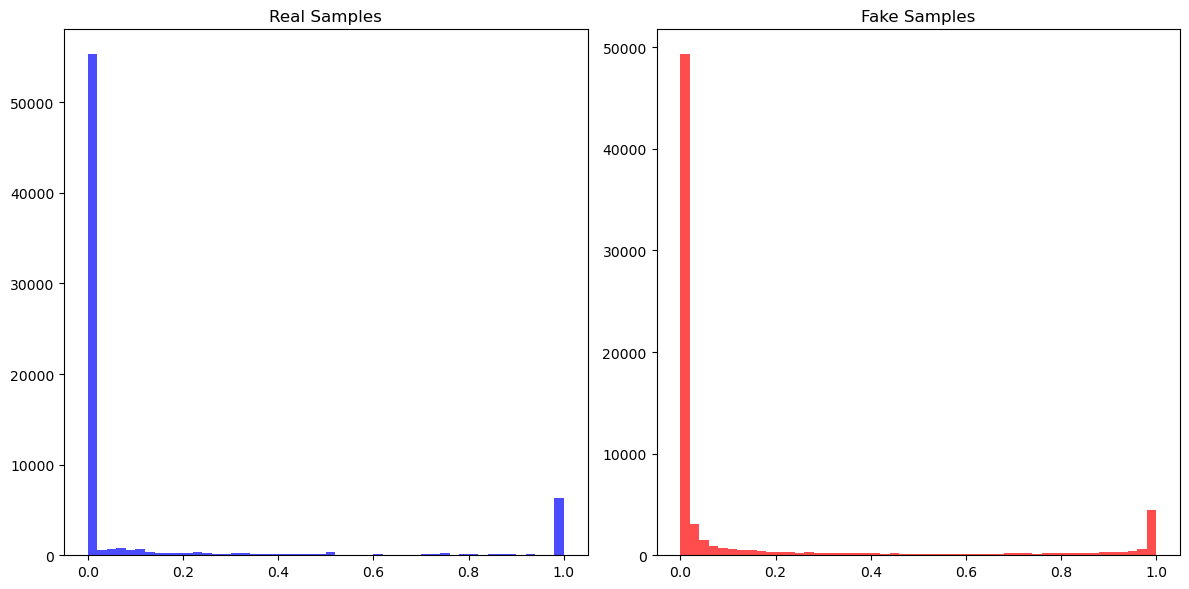

In [162]:
# Get real samples
n_samples = 1000  # Change this based on how many samples you want
real_samples = df_default.sample(n_samples).values.flatten()

# Get fake samples from GAN
fake_samples = default_sample.sample(n_samples).values.flatten()

# Plot
plot_samples(real_samples, fake_samples)


In [163]:
default_sample["loan_status"]=0
df_default["loan_status"]=0
df_paid["loan_status"]=1


In [164]:
daa = pd.concat([default_sample, df_default, df_paid])


In [165]:
daa.describe()

loan_amnt      term  int_rate  installment  emp_length  annual_inc  \
count  608880.00 608880.00 608880.00    608880.00   608880.00   608880.00   
mean        0.33      0.32      0.33         0.33        0.59        0.02   
std         0.25      0.44      0.20         0.26        0.35        0.11   
min         0.00      0.00      0.00         0.00        0.00        0.00   
25%         0.14      0.00      0.17         0.14        0.28        0.00   
50%         0.29      0.00      0.30         0.25        0.60        0.01   
75%         0.48      0.91      0.45         0.46        0.99        0.01   
max         1.00      1.00      1.00         1.00        1.00        1.00   

            dti  earliest_cr_line  open_acc   pub_rec  revol_bal  revol_util  \
count 608880.00         608880.00 608880.00 608880.00  608880.00   608880.00   
mean       0.08              0.73      0.17      0.18       0.02        0.06   
std        0.11              0.21      0.19      0.36       0.09        0.10   
min        0.00              0.00      0.00      0.00       0.00        0.00   
25%        0.02              0.67      0.06      0.00       0.00        0.02   
50%        0.04              0.80      0.10      0.00       0.01        0.05   
75%        0.07              0.87      0.17      0.04       0.01        0.07   
max        1.00              1.00      1.00      1.00       1.00        1.00   

       total_acc  mort_acc  pub_rec_bankruptcies  sub_grade_A2  sub_grade_A3  \
count  608880.00 608880.00             608880.00     608880.00     608880.00   
mean        0.14      0.62                  0.15          0.02          0.03   
std         0.14      0.47                  0.33          0.14          0.15   
min         0.00      0.00                  0.00          0.00          0.00   
25%         0.05      0.00                  0.00          0.00          0.00   
50%         0.11      0.99                  0.00          0.00          0.00   
75%         0.18      1.00                  0.02          0.00          0.00   
max         1.00      1.00                  1.00          1.00          1.00   

       sub_grade_A4  sub_grade_A5  sub_grade_B1  sub_grade_B2  sub_grade_B3  \
count     608880.00     608880.00     608880.00     608880.00     608880.00   
mean           0.04          0.04          0.07          0.05          0.09   
std            0.18          0.19          0.22          0.21          0.27   
min            0.00          0.00          0.00          0.00          0.00   
25%            0.00          0.00          0.00          0.00          0.00   
50%            0.00          0.00          0.00          0.00          0.00   
75%            0.00          0.00          0.02          0.00          0.00   
max            1.00          1.00          1.00          1.00          1.00   

       sub_grade_B4  sub_grade_B5  sub_grade_C1  ...  sub_grade_G4  \
count     608880.00     608880.00     608880.00  ...     608880.00   
mean           0.05          0.07          0.09  ...          0.02   
std            0.20          0.24          0.28  ...          0.12   
min            0.00          0.00          0.00  ...          0.00   
25%            0.00          0.00          0.00  ...          0.00   
50%            0.00          0.00          0.00  ...          0.00   
75%            0.00          0.00          0.00  ...          0.00   
max            1.00          1.00          1.00  ...          1.00   

       sub_grade_G5  verification_status_Source Verified  \
count     608880.00                            608880.00   
mean           0.01                                 0.41   
std            0.09                                 0.47   
min            0.00                                 0.00   
25%            0.00                                 0.00   
50%            0.00                                 0.01   
75%            0.00                                 1.00   
max            1.00                             

In [166]:
daa

loan_amnt  term  int_rate  installment  emp_length  annual_inc  dti  \
0            0.00  0.01      0.17         0.00        0.96        0.00 0.00   
1            0.23  0.99      0.82         0.34        0.19        0.00 0.00   
2            0.28  0.95      0.32         0.86        0.69        0.00 0.45   
3            0.49  1.00      0.52         0.96        0.88        0.00 0.53   
4            0.23  0.99      0.81         0.04        0.03        0.00 0.00   
...           ...   ...       ...          ...         ...         ...  ...   
376924       0.24  1.00      0.22         0.13        0.20        0.00 0.04   
376925       0.52  0.00      0.27         0.45        0.50        0.01 0.06   
376926       0.11  0.00      0.18         0.10        1.00        0.01 0.05   
376927       0.52  1.00      0.39         0.32        1.00        0.01 0.04   
376928       0.04  0.00      0.32         0.03        1.00        0.00 0.02   

        earliest_cr_line  open_acc  pub_rec  revol_bal  revol_util  total_acc  \
0                   0.96      0.20     0.00       0.00        0.01       0.00   
1                   0.20      0.00     0.00       0.00        0.01       0.03   
2                   0.77      0.13     0.02       0.01        0.02       0.07   
3                   0.71      0.11     0.00       0.01        0.02       0.09   
4                   0.55      0.00     0.00       0.00        0.00       0.01   
...                  ...       ...      ...        ...         ...        ...   
376924              0.87      0.06     0.00       0.00        0.04       0.14   
376925              0.90      0.06     0.00       0.02        0.11       0.04   
376926              0.77      0.16     0.00       0.02        0.07       0.14   
376927              0.67      0.09     0.00       0.01        0.06       0.12   
376928              0.78      0.02     0.00       0.00        0.10       0.11   

        mort_acc  pub_rec_bankruptcies  sub_grade_A2  sub_grade_A3  \
0           1.00                  0.00          0.00          0.00   
1           0.99                  0.00          0.00          0.00   
2           0.04                  0.02          0.01          0.01   
3           0.03                  0.00          0.00          0.01   
4           1.00                  0.00          0.00          0.00   
...          ...                   ...           ...           ...   
376924      0.00                  0.00          0.00          0.00   
376925      1.00                  0.00          0.00          0.00   
376926      0.00                  0.00          0.00          0.00   
376927      1.00                  0.00          0.00          0.00   
376928      1.00                  0.00          0.00          0.00   

        sub_grade_A4  sub_grade_A5  sub_grade_B1  sub_grade_B2  sub_grade_B3  \
0               0.00          0.00          0.00          0.00          0.00   
1               0.00          0.00          0.01          0.00          0.00   
2               0.02          0.00          0.10          0.00          0.04   
3               0.02          0.00          0.30          0.00          0.00   
4               0.00          0.00          0.00          0.00          0.00   
...              ...           ...           ...           ...           ...   
376924          0.00          0.00          0.00          0.00          0.00   
376925          0.00          0.00          0.00          0.00          0.00   
376926          0.00          0.00          1.00          0.00          0.00   
376927          0.00          0.00          0.00          0.00          0.00   
376928          0.00          0.00          0.00          0.00          0.00   

        sub_grade_B4  sub_grade_B5  sub_grade_C1  ...  sub_grade_G4  \
0               0.00          0.94          1.00  ...          0.00   
1               0.00          0.01          0.00  ...          0.00   
2               0.00          0.00          0.00  ...          0.00   


In [167]:
features = data.drop('loan_status', axis=1)

# Separating out the features and the target
daafeatures = daa.drop('loan_status', axis=1)
loan_status = daa['loan_status']

# Reverse the Min-Max scaling
reverse_scaled_features = scaler.inverse_transform(daafeatures)
# Convert reversed scaled features back to DataFrame
reverse_scaled_features_df = pd.DataFrame(reverse_scaled_features, columns=features.columns)



In [168]:
loan_status = daa['loan_status']
# Reset the index for reverse_scaled_features_df
reverse_scaled_features_df.reset_index(drop=True, inplace=True)

# Reset the index for loan_status
loan_status.reset_index(drop=True, inplace=True)

# Joining back the loan_status
reversed_data = pd.concat([reverse_scaled_features_df, loan_status], axis=1)




In [169]:
reversed_data

loan_amnt  term  int_rate  installment  emp_length  annual_inc    dti  \
0          597.73 36.15      9.69        19.11        9.58     4360.83   0.23   
1         9717.18 59.68     26.36       527.58        1.87     8940.08   1.02   
2        11532.35 58.91     13.47      1317.13        6.92    18207.53 169.52   
3        19665.49 59.90     18.69      1479.71        8.81    19922.22 202.06   
4         9692.95 59.77     26.19        78.63        0.31     5452.15   0.34   
...           ...   ...       ...          ...         ...         ...    ...   
608875   10000.00 60.00     10.99       217.38        2.00    40000.00  15.63   
608876   21000.00 36.00     12.29       700.42        5.00   110000.00  21.45   
608877    5000.00 36.00      9.99       161.32       10.00    56500.00  17.56   
608878   21000.00 60.00     15.31       503.02       10.00    64000.00  15.88   
608879    2000.00 36.00     13.61        67.98       10.00    42996.00   8.32   

        earliest_cr_line  open_acc  pub_rec  revol_bal  revol_util  total_acc  \
0                2010.34     18.39     0.00      70.55       10.85       2.20   
1                1957.88      1.42     0.00    2694.47        6.38       6.46   
2                1997.34     12.47     0.02   18588.19       14.42      11.97   
3                1993.04     10.85     0.00   10283.11       14.93      15.50   
4                1982.18      1.15     0.00     681.39        2.04       3.22   
...                  ...       ...      ...        ...         ...        ...   
608875           2004.00      6.00     0.00    1990.00       34.30      23.00   
608876           2006.00      6.00     0.00   43263.00       95.70       8.00   
608877           1997.00     15.00     0.00   32704.00       66.90      23.00   
608878           1990.00      9.00     0.00   15704.00       53.80      20.00   
608879           1998.00      3.00     0.00    4292.00       91.30      19.00   

        mort_acc  pub_rec_bankruptcies  sub_grade_A2  sub_grade_A3  \
0           1.00                  0.00          0.00          0.00   
1           0.99                  0.00          0.00          0.00   
2           0.04                  0.02          0.01          0.01   
3           0.03                  0.00          0.00          0.01   
4           1.00                  0.00          0.00          0.00   
...          ...                   ...           ...           ...   
608875      0.00                  0.00          0.00          0.00   
608876      1.00                  0.00          0.00          0.00   
608877      0.00                  0.00          0.00          0.00   
608878      1.00                  0.00          0.00          0.00   
608879      1.00                  0.00          0.00          0.00   

        sub_grade_A4  sub_grade_A5  sub_grade_B1  sub_grade_B2  sub_grade_B3  \
0               0.00          0.00          0.00          0.00          0.00   
1               0.00          0.00          0.01          0.00          0.00   
2               0.02          0.00          0.10          0.00          0.04   
3               0.02          0.00          0.30          0.00          0.00   
4               0.00          0.00          0.00          0.00          0.00   
...              ...           ...           ...           ...           ...   
608875          0.00          0.00          0.00          0.00          0.00   
608876          0.00          0.00          0.00          0.00          0.00   
608877          0.00          0.00          1.00          0.00          0.00   
608878          0.00          0.00          0.00          0.00          0.00   
608879          0.00          0.00          0.00          0.00          0.00   

        sub_grade_B4  sub_grade_B5  sub_grade_C1  ...  sub_grade_G4  \
0               0.00          0.94          1.00  ...          0.00   
1               0.00          0.01          0.00  ...          0.00   
2               0.00          0.00          0.0

# Scaling

In [171]:
from sklearn.preprocessing import MinMaxScaler

# Separating out the features and the target
daz = reversed_data.drop('loan_status', axis=1)
loan_status = reversed_data['loan_status']


# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Assuming 'data' is your DataFrame
scaled_data1 = scaler.fit_transform(daz)

# Convert scaled_data back to a DataFrame
scaled_data_df1 = pd.DataFrame(scaled_data1, columns=daz.columns)



In [172]:
# Adding loan_status back to the scaled DataFrame using assign
scaled_data_df1 = scaled_data_df1.assign(loan_status=loan_status.values)

# OR

# Using bracket notation
scaled_data_df1['loan_status'] = loan_status.values


In [173]:
train, test = train_test_split(scaled_data_df1, test_size=0.2, random_state=42)

print(train.shape)
print(test.shape)

(487104, 72)
(121776, 72)


In [174]:
train


loan_amnt  term  int_rate  installment  emp_length  annual_inc  dti  \
391484       0.37  0.00      0.26         0.32        1.00        0.01 0.04   
203479       0.12  0.69      0.12         0.82        0.65        0.00 0.30   
371857       0.47  1.00      0.35         0.29        1.00        0.00 0.03   
383312       0.37  0.00      0.45         0.34        0.50        0.01 0.08   
117567       0.08  0.02      0.22         0.43        0.43        0.00 0.04   
...           ...   ...       ...          ...         ...         ...  ...   
110268       0.33  0.97      0.64         0.04        0.12        0.00 0.01   
259178       0.49  1.00      0.34         0.30        0.20        0.01 0.02   
365838       0.28  0.00      0.52         0.27        0.60        0.00 0.04   
131932       0.01  0.00      0.21         0.13        0.22        0.00 0.03   
121958       0.04  0.00      0.18         0.01        0.94        0.00 0.00   

        earliest_cr_line  open_acc  pub_rec  revol_bal  revol_util  total_acc  \
391484              0.78      0.16     0.00       0.01        0.07       0.21   
203479              0.70      0.07     0.12       0.02        0.02       0.05   
371857              0.65      0.17     0.00       0.01        0.05       0.26   
383312              0.80      0.09     1.00       0.00        0.08       0.13   
117567              0.92      0.50     0.90       0.02        0.07       0.08   
...                  ...       ...      ...        ...         ...        ...   
110268              0.12      0.01     0.00       0.00        0.00       0.01   
259178              0.90      0.15     1.00       0.00        0.04       0.17   
365838              0.91      0.03     0.00       0.00        0.10       0.03   
131932              0.82      0.73     0.99       0.00        0.03       0.02   
121958              0.84      0.56     0.29       0.00        0.03       0.05   

        mort_acc  pub_rec_bankruptcies  sub_grade_A2  sub_grade_A3  \
391484      1.00                  0.00          0.00          0.00   
203479      0.11                  0.09          0.01          0.00   
371857      1.00                  0.00          0.00          0.00   
383312      1.00                  1.00          0.00          0.00   
117567      0.96                  0.79          0.00          0.00   
...          ...                   ...           ...           ...   
110268      1.00                  0.00          0.00          0.00   
259178      0.00                  0.00          0.00          0.00   
365838      0.00                  0.00          0.00          0.00   
131932      0.98                  0.98          0.00          0.00   
121958      0.99                  0.14          0.00          0.00   

        sub_grade_A4  sub_grade_A5  sub_grade_B1  sub_grade_B2  sub_grade_B3  \
391484          0.00          0.00          0.00          0.00          1.00   
203479          0.01          0.00          0.07          0.00          0.23   
371857          0.00          0.00          0.00          0.00          0.00   
383312          0.00          0.00          0.00          0.00          0.00   
117567          0.05          0.01          0.10          0.01          0.00   
...              ...           ...           ...           ...           ...   
110268          0.00          0.00          0.00          0.00          0.00   
259178          0.00          0.00          0.00          0.00          0.00   
365838          0.00          0.00          0.00          0.00          0.00   
131932          0.01          0.02          0.03          0.00          0.00   
121958          0.00          0.00          0.01          0.00          0.00   

        sub_grade_B4  sub_grade_B5  sub_grade_C1  ...  sub_grade_G4  \
391484          0.00          0.00          0.00  ...          0.00   
203479          0.00          0.00          0.00  ...          0.00   
371857          0.00          0.00          0.00  ...          0.00   


In [175]:
X_train, y_train = train.drop('loan_status', axis=1), train.loan_status
X_test, y_test = test.drop('loan_status', axis=1), test.loan_status

# CNN

In [177]:
X_trainn = np.expand_dims(X_train, axis=2)


In [178]:
# reshape data for CNN
X_testt = np.expand_dims(X_test, axis=2)

In [179]:
X_testt.shape

(121776, 71, 1)

In [180]:
X_trainn.shape[1]

71

In [181]:
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)


In [241]:
import numpy as np
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.regularizers import l2
import random


# Function to create the CNN model
def create_cnn_model(num_conv_layers=2, num_filters=64, kernel_size=3, 
                     stride=1, pooling_size=2, num_dense_layers=1, 
                     dense_units=128, dropout_rate=0.5, learning_rate=0.001, 
                     optimizer='adam', activation='relu', l2_regularization=0.0001):
    model = Sequential()
    
    # Add Convolutional and Pooling layers
    for i in range(num_conv_layers):
        if i == 0:
            model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, strides=stride, 
                             activation=activation, padding='same', 
                             input_shape=(71, 1), kernel_regularizer=l2(l2_regularization)))
        else:
            model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, strides=stride, 
                             activation=activation, padding='same', kernel_regularizer=l2(l2_regularization)))
        model.add(MaxPooling1D(pool_size=pooling_size))
    
    model.add(Flatten())
    
    # Add multiple Dense layers
    for _ in range(num_dense_layers):
        model.add(Dense(dense_units, activation=activation))
        model.add(Dropout(dropout_rate))
    
    # Output layer
    model.add(Dense(y_train_encoded.shape[1], activation='softmax'))
    
    # Compile the model
    if optimizer == 'adam':
        optimizer_instance = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        optimizer_instance = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        optimizer_instance = SGD(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Define the hyperparameter space with lists of discrete values
param_dist = {
    'num_conv_layers': [1, 2, 3, 4],             # Number of Conv layers
    'num_filters': [32, 64, 96, 128],                # Number of filters
    'kernel_size': [2, 3, 4],                    # Kernel size options
    'stride': [1],                            # Stride options
    'pooling_size': [2],                      # Pooling size options
    'num_dense_layers': [1, 2, 3,4,5],               # Number of Dense layers
    'dense_units': [64, 128, 180, 256],               # Dense units options
    'dropout_rate': [0.2, 0.3, 0.4, 0.5],        # Dropout rate options
    'learning_rate': [0.0001, 0.001, 0.005, 0.01, 0.1],       # Learning rate options
    'batch_size': [16, 32, 64, 128],             # Batch size options
    'optimizer': ['adam', 'rmsprop', 'sgd'],     # Optimizer options
    'activation': ['relu', 'leaky_relu', 'elu'], # Activation function options
    'l2_regularization': [0.0001, 0.001, 0.005, 0.01, 0.1] # L2 regularization options
}

# Function to randomly sample hyperparameters
def sample_hyperparameters(param_dist):
    sampled_params = {}
    for param, values in param_dist.items():
        sampled_params[param] = random.choice(values)  # Sample a value from the list
    return sampled_params

# List to store the results
results = []

# Perform random search for a fixed number of iterations (e.g., 10)
for iteration in range(10):
    print(f"Iteration {iteration + 1}")
    
    # Sample random hyperparameters
    params = sample_hyperparameters(param_dist)
    
    # Create the CNN model with sampled hyperparameters
    model = create_cnn_model(
        num_conv_layers=params['num_conv_layers'],
        num_filters=params['num_filters'],
        kernel_size=params['kernel_size'],
        stride=params['stride'],
        pooling_size=params['pooling_size'],
        num_dense_layers=params['num_dense_layers'],  # Vary the number of Dense layers
        dense_units=params['dense_units'],
        dropout_rate=params['dropout_rate'],
        learning_rate=params['learning_rate'],
        optimizer=params['optimizer'],
        activation=params['activation'],
        l2_regularization=params['l2_regularization']
    )
    
    # Train the model
    history = model.fit(X_trainn, y_train_encoded, 
                        validation_data=(X_testt, y_test_encoded),
                        epochs=10, batch_size=int(params['batch_size']), verbose=1)
    
    # Evaluate the model on the test data
    test_loss, test_accuracy = model.evaluate(X_testt, y_test_encoded, verbose=0)
    
    print(f"Test Accuracy: {test_accuracy}")
    
    # Store the result
    results.append({
        'params': params,
        'accuracy': test_accuracy
    })

# Step 5: Sort results by accuracy in descending order
sorted_results = sorted(results, key=lambda x: x['accuracy'], reverse=True)

# Output the top 3 models
print("Top 3 Best Models:")

for i in range(3):
    print(f"Rank {i + 1}")
    print(f"Accuracy: {sorted_results[i]['accuracy']}")
    print(f"Hyperparameters: {sorted_results[i]['params']}")
    print("-" * 30)

Iteration 1
Epoch 1/10


C:\Users\bghsi\ana\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


15222/15222 ━━━━━━━━━━━━━━━━━━━━ 54s 3ms/step - accuracy: 0.8772 - loss: 0.3071 - val_accuracy: 0.9138 - val_loss: 0.2301
Epoch 2/10
15222/15222 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9129 - loss: 0.2292 - val_accuracy: 0.9128 - val_loss: 0.2144
Epoch 3/10
15222/15222 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9142 - loss: 0.2098 - val_accuracy: 0.9243 - val_loss: 0.1917
Epoch 4/10
15222/15222 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - accuracy: 0.9272 - loss: 0.1866 - val_accuracy: 0.9310 - val_loss: 0.1760
Epoch 5/10
15222/15222 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9311 - loss: 0.1779 - val_accuracy: 0.9316 - val_loss: 0.1741
Epoch 6/10
15222/15222 ━━━━━━━━━━━━━━━━━━━━ 51s 3ms/step - accuracy: 0.9321 - loss: 0.1750 - val_accuracy: 0.9315 - val_loss: 0.1746
Epoch 7/10
15222/15222 ━━━━━━━━━━━━━━━━━━━━ 50s 3ms/step - accuracy: 0.9319 - loss: 0.1742 - val_accuracy: 0.9315 - val_loss: 0.1729
Epoch 8/10
15222/15222 ━━━━━━━━━━━━━━━━━━━━ 52s 3ms/step - accuracy: 0.9315 - lo

In [327]:
import numpy as np
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Function to create a CNN model
def create_cnn_model(params):
    model = Sequential()
    for i in range(params['num_conv_layers']):
        if i == 0:
            model.add(Conv1D(filters=params['num_filters'], kernel_size=params['kernel_size'],
                             strides=params['stride'], activation=params['activation'],
                             padding='same', kernel_regularizer=l2(params['l2_regularization']),
                             input_shape=(71, 1)))  # Assuming the input shape is (71, 1)
        else:
            model.add(Conv1D(filters=params['num_filters'], kernel_size=params['kernel_size'],
                             strides=params['stride'], activation=params['activation'],
                             padding='same', kernel_regularizer=l2(params['l2_regularization'])))
        model.add(MaxPooling1D(pool_size=params['pooling_size']))
    model.add(Flatten())
    for _ in range(params['num_dense_layers']):
        model.add(Dense(params['dense_units'], activation=params['activation']))
        model.add(Dropout(params['dropout_rate']))
    model.add(Dense(y_train_encoded.shape[1], activation='softmax'))  # Ensure y_train_encoded is correct
    if params['optimizer'] == 'rmsprop':
        optimizer_instance = RMSprop(learning_rate=params['learning_rate'])
    elif params['optimizer'] == 'adam':
        optimizer_instance = Adam(learning_rate=params['learning_rate'])
    model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define the top 3 model parameters as you listed
top_3_models_params = [
    {'num_conv_layers': 3, 'num_filters': 64, 'kernel_size': 4, 'stride': 1, 'pooling_size': 2, 'num_dense_layers': 1, 'dense_units': 64, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 128, 'optimizer': 'rmsprop', 'activation': 'leaky_relu', 'l2_regularization': 0.0001},
    {'num_conv_layers': 1, 'num_filters': 32, 'kernel_size': 4, 'stride': 1, 'pooling_size': 2, 'num_dense_layers': 2, 'dense_units': 180, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'batch_size': 32, 'optimizer': 'adam', 'activation': 'relu', 'l2_regularization': 0.005},
    {'num_conv_layers': 2, 'num_filters': 32, 'kernel_size': 4, 'stride': 1, 'pooling_size': 2, 'num_dense_layers': 5, 'dense_units': 256, 'dropout_rate': 0.4, 'learning_rate': 0.0001, 'batch_size': 32, 'optimizer': 'rmsprop', 'activation': 'relu', 'l2_regularization': 0.005}
]

# Create models
models = [create_cnn_model(params) for params in top_3_models_params]

# Train each model (Assuming X_trainn, y_train_encoded are available and appropriate for training)
for model, params in zip(models, top_3_models_params):
    model.fit(X_trainn, y_train_encoded, epochs=10, batch_size=params['batch_size'], verbose=1, validation_split=0.2)


C:\Users\bghsi\ana\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.8875 - loss: 0.2890 - val_accuracy: 0.9142 - val_loss: 0.2264
Epoch 2/10
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - accuracy: 0.9272 - loss: 0.1962 - val_accuracy: 0.9308 - val_loss: 0.1827
Epoch 3/10
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - accuracy: 0.9312 - loss: 0.1841 - val_accuracy: 0.9312 - val_loss: 0.1837
Epoch 4/10
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - accuracy: 0.9311 - loss: 0.1817 - val_accuracy: 0.9310 - val_loss: 0.1812
Epoch 5/10
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 35s 11ms/step - accuracy: 0.9311 - loss: 0.1802 - val_accuracy: 0.9316 - val_loss: 0.1777
Epoch 6/10
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 36s 12ms/step - accuracy: 0.9313 - loss: 0.1788 - val_accuracy: 0.9311 - val_loss: 0.1777
Epoch 7/10
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.9322 - loss: 0.1771 - val_accuracy: 0.9313 - val_loss: 0.1785
Epoch 8/10
3045/3045 ━━━━━━━━━━━━━━━━━━━━ 36s 12ms/step - accuracy: 0.9311 -

# stacked model

In [328]:

# Predicting with each model to form the ensemble features
ensemble_features_train = np.hstack([model.predict(X_trainn) for model in models])
ensemble_features_test = np.hstack([model.predict(X_testt) for model in models])

# Train the Decision Tree as the meta-learner
meta_learner = DecisionTreeClassifier(max_depth=10, min_samples_split=4, min_samples_leaf=2, random_state=42)
meta_learner.fit(ensemble_features_train, np.argmax(y_train_encoded, axis=1))  # Assuming y_train_encoded is categorical encoded

# Predict on the test set using the meta-learner
predictions_test = meta_learner.predict(ensemble_features_test)

# Calculate accuracy on the test set
accuracy_test = accuracy_score(np.argmax(y_test_encoded, axis=1), predictions_test)
print("Test Accuracy:", accuracy_test)


15222/15222 ━━━━━━━━━━━━━━━━━━━━ 41s 3ms/step
15222/15222 ━━━━━━━━━━━━━━━━━━━━ 20s 1ms/step
15222/15222 ━━━━━━━━━━━━━━━━━━━━ 34s 2ms/step
3806/3806 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step
3806/3806 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3806/3806 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step
Test Accuracy: 0.9308895020365261


In [392]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier

# Assuming that the ensemble_features_train and ensemble_features_test have been created as per your previous code

# Train and evaluate the Random Forest Classifier
random_forest_meta_learner = RandomForestClassifier(n_estimators=100, max_depth=20, random_state=42)
random_forest_meta_learner.fit(ensemble_features_train, np.argmax(y_train_encoded, axis=1))
rf_predictions_test = random_forest_meta_learner.predict(ensemble_features_test)
rf_accuracy_test = accuracy_score(np.argmax(y_test_encoded, axis=1), rf_predictions_test)
print("Random Forest Test Accuracy:", rf_accuracy_test)


Random Forest Test Accuracy: 0.9312508211798712


In [362]:

# Train and evaluate the XGBoost Classifier
xgb_meta_learner = XGBClassifier(n_estimators=500, max_depth=2, random_state=42)
xgb_meta_learner.fit(ensemble_features_train, np.argmax(y_train_encoded, axis=1))
xgb_predictions_test = xgb_meta_learner.predict(ensemble_features_test)
xgb_accuracy_test = accuracy_score(np.argmax(y_test_encoded, axis=1), xgb_predictions_test)
print("XGBoost Test Accuracy:", xgb_accuracy_test)


XGBoost Test Accuracy: 0.9316449875180659


In [404]:

# Train and evaluate the K-Nearest Neighbors Classifier
knn_meta_learner = KNeighborsClassifier(n_neighbors=19)
knn_meta_learner.fit(ensemble_features_train, np.argmax(y_train_encoded, axis=1))
knn_predictions_test = knn_meta_learner.predict(ensemble_features_test)
knn_accuracy_test = accuracy_score(np.argmax(y_test_encoded, axis=1), knn_predictions_test)
print("KNN Test Accuracy:", knn_accuracy_test)


KNN Test Accuracy: 0.9300683221652871


# SHap 

In [325]:
import shap
background = X_testt[np.random.choice(X_testt.shape[0], 1000, replace=False)]

exs = shap.DeepExplainer(best_model1, background)


C:\Users\bghsi\ana\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


In [327]:
shapval = exs.shap_values(background)

In [343]:
print(np.array(shapval).shape)



(1000, 71, 1, 2)


In [335]:
pred = best_model1.predict(background)
pred[0:10]

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


array([[3.04335572e-07, 9.99999642e-01],
       [1.11276815e-04, 9.99888659e-01],
       [1.37530029e-01, 8.62469971e-01],
       [1.00000000e+00, 3.86980004e-15],
       [7.84451067e-02, 9.21554863e-01],
       [1.54621914e-01, 8.45378101e-01],
       [1.00000000e+00, 5.75824591e-16],
       [9.98936713e-01, 1.06324174e-03],
       [7.51971453e-02, 9.24802840e-01],
       [1.00000000e+00, 9.10586888e-16]], dtype=float32)

In [410]:
col=scaled_data_df1.drop(columns=["loan_status"])

In [369]:
pred=np.argmax(pred, axis=1)



In [373]:
pred[0:30]

array([1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 1, 1, 1, 1], dtype=int64)

In [355]:
shapv = np.array(shapval)  # ensure shapv is a numpy array
shapv_reshaped = np.squeeze(shapv, axis=2)


In [357]:

print(np.array(shapv_reshaped).shape)


(1000, 71, 2)


In [413]:
background_reshaped.shape

(1000, 71)

In [419]:
#class 1 (no default (fully paid))
shap.initjs()
shap.force_plot(exs.expected_value[1].numpy(), shapv_reshaped[4, :, 1], background[4],feature_names=col.columns)

In [387]:
#class 1 (no default (fully paid))
shap.initjs()
shap.force_plot(exs.expected_value[0].numpy(), shapv_reshaped[7, :, 0], background[7],feature_names=col.columns)

In [415]:
#class 1 (no default (fully paid))
shap.initjs()
shap.force_plot(exs.expected_value[1].numpy(), shapv_reshaped[44, :, 1], background[44,:],feature_names=col.columns)

In [425]:
#class 1 (no default )
shap.initjs()
shap.force_plot(exs.expected_value[0].numpy(), shapv_reshaped[0][87], background_reshaped[8],feature_names=col.columns)

In [409]:
background_reshaped = np.squeeze(background, axis=-1)


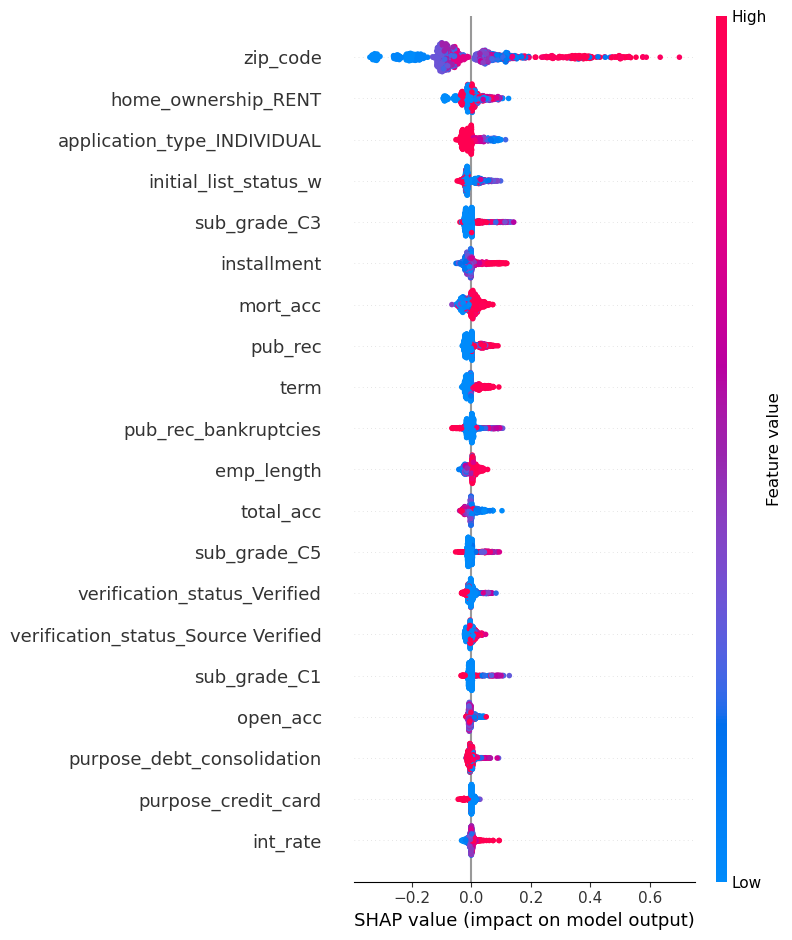

In [411]:
shap.summary_plot(shapv_reshaped[:,:,0],
                  background_reshaped, 
                  feature_names=col.columns)

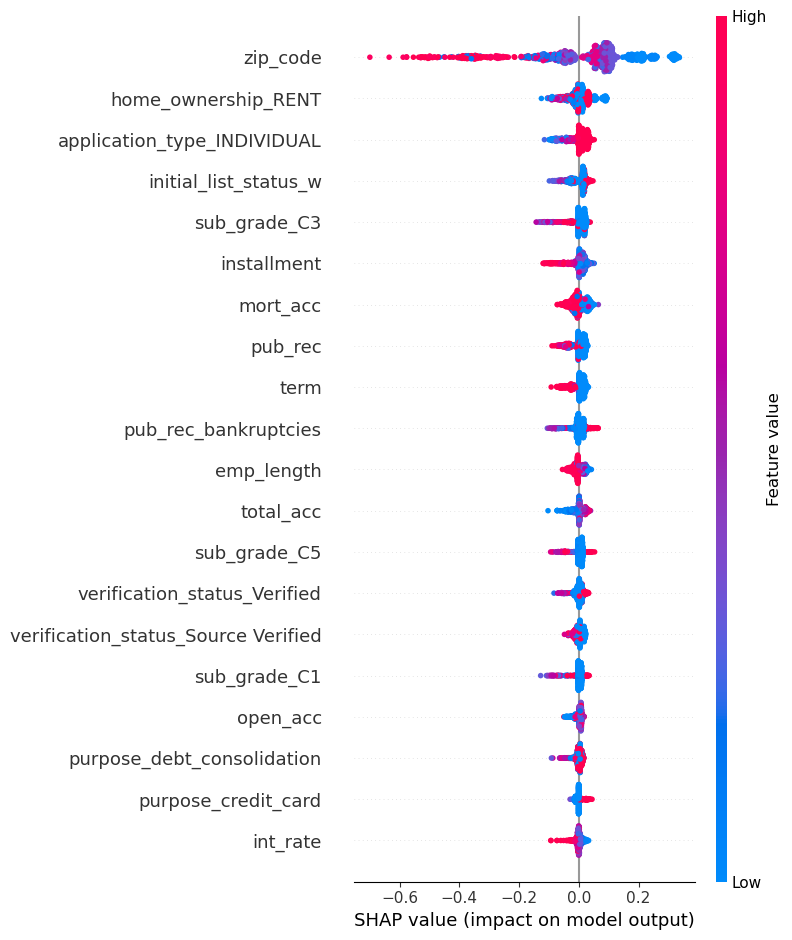

In [417]:
shap.summary_plot(shapv_reshaped[:,:,1],
                  background_reshaped, 
                  feature_names=col.columns)

# Lime

In [438]:
!pip install lightgbm

   ---------------------------------------- 0.0/1.4 MB ? eta -:--:--
    --------------------------------------- 0.0/1.4 MB 660.6 kB/s eta 0:00:03
   --- ------------------------------------ 0.1/1.4 MB 1.8 MB/s eta 0:00:01
   ------ --------------------------------- 0.2/1.4 MB 2.0 MB/s eta 0:00:01
   ------ --------------------------------- 0.2/1.4 MB 2.0 MB/s eta 0:00:01
   --------- ------------------------------ 0.3/1.4 MB 1.7 MB/s eta 0:00:01
   -------------- ------------------------- 0.5/1.4 MB 2.1 MB/s eta 0:00:01
   --------------- ------------------------ 0.6/1.4 MB 2.2 MB/s eta 0:00:01
   -------------------- ------------------- 0.7/1.4 MB 2.1 MB/s eta 0:00:01
   ---------------------- ----------------- 0.8/1.4 MB 2.2 MB/s eta 0:00:01
   -------------------------- ------------- 0.9/1.4 MB 2.2 MB/s eta 0:00:01
   ---------------------------- ----------- 1.0/1.4 MB 2.2 MB/s eta 0:00:01
   ------------------------------- -------- 1.1/1.4 MB 2.2 MB/s eta 0:00:01
   --------------

C:\Users\bghsi\ana\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\bghsi\ana\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\bghsi\ana\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

<Figure size 800x600 with 0 Axes>

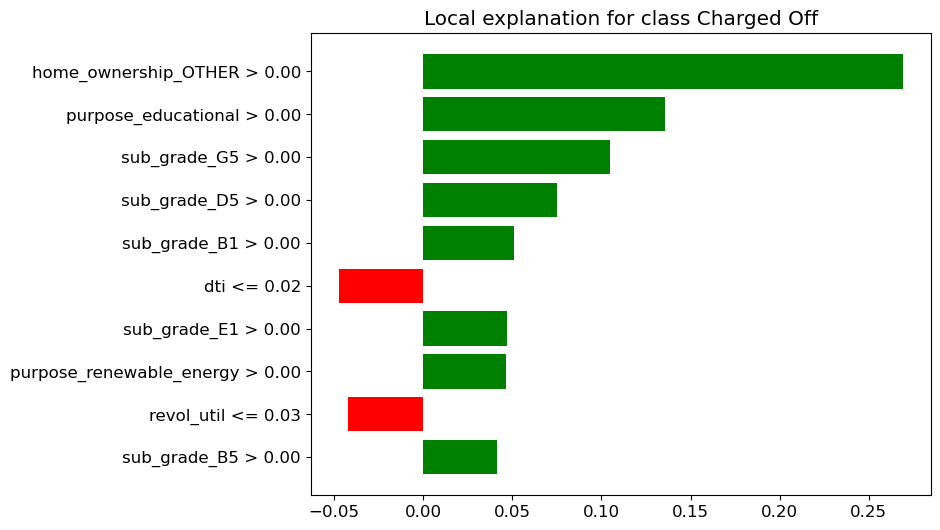

In [448]:
import numpy as np
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

best_model1 = models[0]

def predict_function(data):
    data = data.reshape(data.shape[0], data.shape[1], 1)  
    return best_model1.predict(data)

explainer = LimeTabularExplainer(
    training_data=np.squeeze(X_trainn),  
    feature_names=col.columns, 
    class_names=['Charged Off', 'Fully Paid'],
    mode='classification'
)

i = 0 

exp = explainer.explain_instance(
    data_row=np.squeeze(X_testt[i]), 
    predict_fn=predict_function,  
    num_features=10  
)

predicted_probabilities = predict_function(np.array([np.squeeze(X_testt[i])]))
predicted_label_index = 0 if predicted_probabilities[0][0] < 0.5 else 1  

plt.figure(figsize=(8, 6))

if exp.available_labels():
    label_to_explain = predicted_label_index 
    exp_fig = exp.as_pyplot_figure(label=label_to_explain)
    exp_fig.set_size_inches(8, 6) 
    plt.rcParams.update({'font.size': 12})
    plt.show()
else:
    print("No explanations available for the specified label.")


C:\Users\bghsi\ana\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\bghsi\ana\Lib\site-packages\lime\discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
C:\Users\bghsi\ana\Lib\site-packages\lime\lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]

<Figure size 800x600 with 0 Axes>

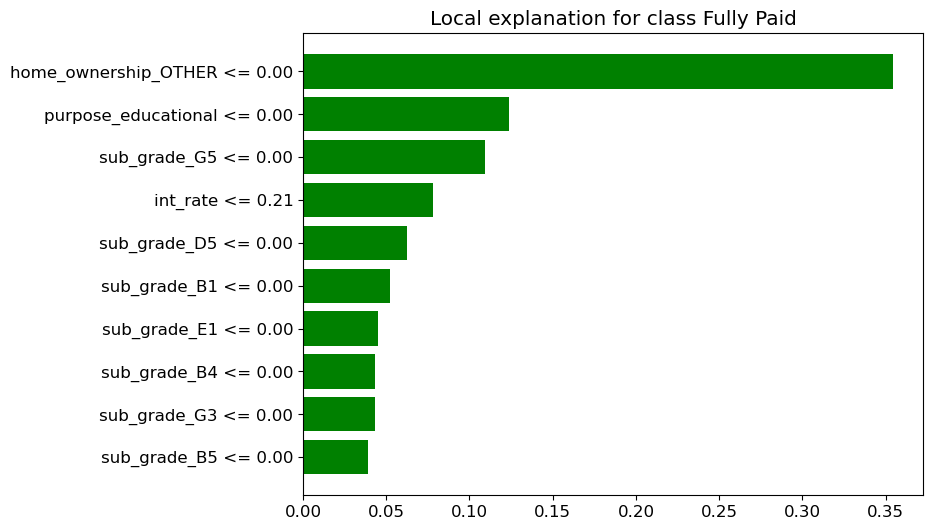

In [472]:
import numpy as np
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.regularizers import l2
from lime.lime_tabular import LimeTabularExplainer
import matplotlib.pyplot as plt

i = 0  

# Explanation for the specific test instance
exp = explainer.explain_instance(
    data_row=np.squeeze(X_testt[i]),  
    predict_fn=predict_function, 
    num_features=10  
)

predicted_probabilities = predict_function(np.array([np.squeeze(X_testt[i])]))
predicted_label_index = 0 if predicted_probabilities[0][0] < 0.5 else 1 

plt.figure(figsize=(8, 6))

if exp.available_labels():
    label_to_explain = predicted_label_index  
    exp_fig = exp.as_pyplot_figure(label=label_to_explain)
    exp_fig.set_size_inches(8, 6)  
    plt.rcParams.update({'font.size': 12}) 
    plt.show()
else:
    print("No explanations available for the specified label.")


<Figure size 800x600 with 0 Axes>

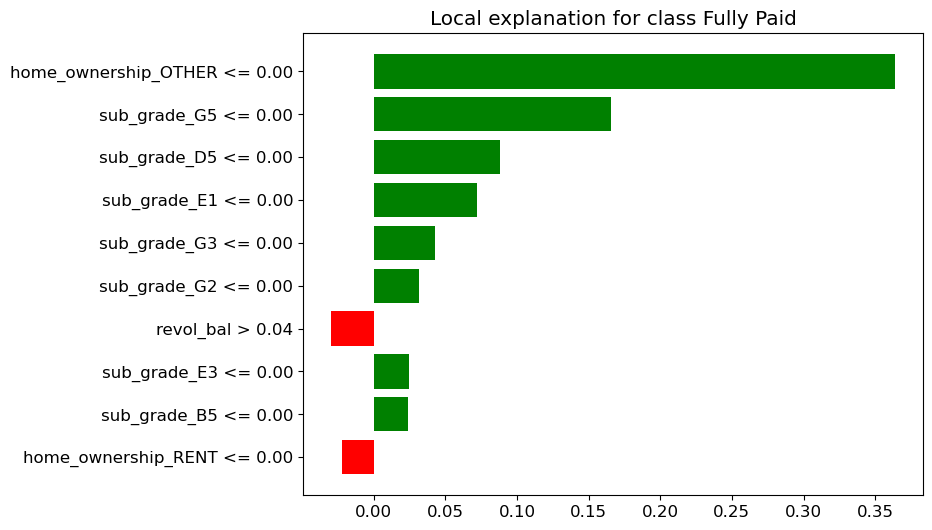

In [245]:
import matplotlib.pyplot as plt
from lime import lime_tabular

# Assuming you have already created a model and prepared your dataset
explainer = lime_tabular.LimeTabularExplainer(training_data=X_train.values,
                                              feature_names=X_train.columns,
                                              class_names=['Charged Off', 'Fully Paid'],
                                              mode='classification')

# Explain a prediction
exp = explainer.explain_instance(data_row=X_test.iloc[209], predict_fn=lgbm.predict_proba)
plt.figure(figsize=(8, 6))

# Plot the explanation
exp_fig = exp.as_pyplot_figure()
exp_fig.set_size_inches(8, 6)  # Resize the figure that has been created by LIME

# Adjust font sizes if necessary
plt.rcParams.update({'font.size': 12})  # Adjust font size here

plt.show()


# PFI

In [476]:
pip install lightgbm scikit-learn eli5


  Using cached eli5-0.13.0-py2.py3-none-any.whl
   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   ---------------------------------------- 0.0/47.1 kB ? eta -:--:--
   -------- ------------------------------- 10.2/47.1 kB ? eta -:--:--
   -------- ------------------------------- 10.2/47.1 kB ? eta -:--:--
   -------- ------------------------------- 10.2/47.1 kB ? eta -:--:--
   -------- ------------------------------- 10.2/47.1 kB ? eta -:--:--
   ----------------- ---------------------- 20.5/47.1 kB 59.5 kB/s eta 0:00:01
   ----------------- ---------------------- 20.5/47.1 kB 59.5 kB/s eta 0:00:01
   ----------------- ---------------------- 20.5/47.1 kB 59.5 kB/s eta 0:00:01
   ----------------- ---------------------- 20.5/47.1 kB 59.5 kB/s eta 0:00:01
   ----------------- ---------------------- 20.5/47.1 kB 59.5 kB/s eta 0:00:01
   ---------------------------------------- 47.1/47.1 kB 90.6 kB/s eta 0:00:00
Note: you may need to restart the kernel to use update

In [197]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from tensorflow.keras.models import Sequential

best_model1 = models[0]

def predict_function(X):
    X_reshaped = X.reshape(-1, 71, 1)
    predictions = best_model1.predict(X_reshaped)
    return np.argmax(predictions, axis=1)

# Compute Permutation Feature Importance
results = permutation_importance(
    estimator=predict_function, 
    X=np.squeeze(X_testt),  
    y=np.argmax(y_test_encoded, axis=1), 
    scoring='accuracy', 
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Results and Plotting
importances = results.importances_mean
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 8))
plt.title("Feature importances using Permutation Importance")
plt.bar(range(X_testt.shape[1]), importances[indices], color="r", align="center")
plt.xticks(range(X_testt.shape[1]), indices)
plt.xlim([-1, X_testt.shape[1]])
plt.xlabel('Feature Index')
plt.ylabel('Mean Decrease in Accuracy')
plt.show()


## Identity

In [337]:
import numpy as np
import shap

def evaluate_identity_axiom_repeatability(model, X_test, num_trials=10, sample_size=100):
    background = X_test[:100]  
    
    explainer = shap.DeepExplainer(model, background)
    
    num_instances = min(sample_size, X_test.shape[0])

    random_indices = np.random.choice(X_test.shape[0], num_instances, replace=False)
    random_sample = X_test[random_indices]  

    violated = 0

    for i, instance in enumerate(random_sample):
        shap_values_first = None

        for _ in range(num_trials):
            shap_values = explainer.shap_values(instance.reshape(1, 71, 1))  

            if shap_values_first is None:
                shap_values_first = shap_values
            else:
                if not np.allclose(shap_values, shap_values_first, atol=1e-6):
                    violated += 1
                    break

    satisfied = num_instances - violated
    percent_satisfied = (satisfied / num_instances) * 100
    return percent_satisfied

identity_axiom_satisfaction = evaluate_identity_axiom_repeatability(best_model1, X_testt)
print(f"Percentage of Identity Axiom Satisfaction: {identity_axiom_satisfaction}%")


C:\Users\bghsi\ana\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


Percentage of Identity Axiom Satisfaction: 100.0%


In [351]:
import numpy as np
import lime
import lime.lime_tabular

def evaluate_identity_axiom_repeatability(model, X_test, num_trials=10, sample_size=100):
    num_samples = X_test.shape[0]
    flat_X_test = X_test.reshape(num_samples, -1)  

    explainer = lime.lime_tabular.LimeTabularExplainer(
        training_data=flat_X_test,
        mode='classification',
        feature_names=[f'Feature {i + 1}' for i in range(71)],
        class_names=['Class 0', 'Class 1'],  # Adjust if different classes are used
        discretize_continuous=True
    )

    num_instances = min(sample_size, X_test.shape[0])
    random_indices = np.random.choice(num_samples, num_instances, replace=False)
    random_sample = flat_X_test[random_indices]

    violated = 0

    for i, instance in enumerate(random_sample):
        lime_values_first = None

        for _ in range(num_trials):
            reshaped_instance = instance.reshape(1, 71, 1)

            # Generate LIME explanation
            explanation = explainer.explain_instance(
                reshaped_instance.flatten(),
                lambda x: model.predict(x.reshape(-1, 71, 1)),
                num_features=10
            )

            # Check for class 0 or class 1 in local_exp
            if 0 in explanation.local_exp:
                lime_values = explanation.local_exp[0]
            elif 1 in explanation.local_exp:
                lime_values = explanation.local_exp[1]
            else:
                print("Class indices not found in local explanation.")
                continue

            if lime_values_first is None:
                lime_values_first = lime_values
            else:
                if not np.allclose(lime_values, lime_values_first, atol=1e-6):
                    violated += 1
                    break

    satisfied = num_instances - violated
    percent_satisfied = (satisfied / num_instances) * 100
    return percent_satisfied

# Evaluate the model
identity_axiom_satisfaction = evaluate_identity_axiom_repeatability(best_model1, X_testt)
print(f"Percentage of Identity Axiom Satisfaction: {identity_axiom_satisfaction}%")


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
157/157 ━━━━━━━━

In [353]:
import numpy as np
from sklearn.metrics import accuracy_score

def evaluate_identity_axiom_repeatability(model, X_test, num_trials=10, sample_size=100):
    num_instances = min(sample_size, X_test.shape[0])
    random_indices = np.random.choice(X_test.shape[0], num_instances, replace=False)
    random_sample = X_test[random_indices]  # Shape should be (num_instances, 71, 1)

    violated = 0

    for i, instance in enumerate(random_sample):
        pfi_values_first = None

        for _ in range(num_trials):
            pfi_values = []
            baseline_accuracy = accuracy_score(
                np.argmax(model.predict(instance.reshape(1, 71, 1)), axis=1), 
                np.argmax(model.predict(instance.reshape(1, 71, 1)), axis=1)
            )

            for feature_idx in range(instance.shape[1]):
                permuted_instance = instance.copy()
                permuted_instance[:, feature_idx] = np.random.permutation(permuted_instance[:, feature_idx])
                permuted_accuracy = accuracy_score(
                    np.argmax(model.predict(permuted_instance.reshape(1, 71, 1)), axis=1), 
                    np.argmax(model.predict(instance.reshape(1, 71, 1)), axis=1)
                )
                pfi_values.append(baseline_accuracy - permuted_accuracy)
            
            pfi_values = np.array(pfi_values)

            if pfi_values_first is None:
                pfi_values_first = pfi_values
            else:
                # Check if the new PFI values are close to the initial PFI values
                if not np.allclose(pfi_values, pfi_values_first, atol=1e-6):
                    violated += 1
                    break

    satisfied = num_instances - violated
    percent_satisfied = (satisfied / num_instances) * 100
    return percent_satisfied

identity_axiom_satisfaction = evaluate_identity_axiom_repeatability(best_model1, X_testt)
print(f"Percentage of Identity Axiom Satisfaction: {identity_axiom_satisfaction}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━

## Stability

In [376]:
import numpy as np
import shap
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score

def evaluate_stability_axiom(model, X_test, y_test_encoded, sample_size=100):
    background = X_test[:100]  # Representative background dataset
    explainer = shap.DeepExplainer(model, background)

    num_instances = min(sample_size, len(X_test))

    random_indices = np.random.choice(range(len(X_test)), num_instances, replace=False)
    random_sample = X_test[random_indices]
    random_labels_encoded = y_test_encoded[random_indices]

    random_labels = np.argmax(random_labels_encoded, axis=1)

    shap_values = explainer.shap_values(random_sample)

    shap_values = shap_values[0] if isinstance(shap_values, list) else shap_values

    flattened_shap_values = shap_values.reshape((num_instances, -1))

    centroid_0 = np.mean([flattened_shap_values[i] for i in range(num_instances) if random_labels[i] == 0], axis=0)
    centroid_1 = np.mean([flattened_shap_values[i] for i in range(num_instances) if random_labels[i] == 1], axis=0)

    kmeans = KMeans(n_clusters=2, init=np.array([centroid_0, centroid_1]), n_init=1)
    kmeans.fit(flattened_shap_values)

    binary_labels = [1 if label == 1 else 0 for label in random_labels]
    jaccard_sim = jaccard_score(binary_labels, kmeans.labels_)
    return jaccard_sim

stability_axiom_similarity = evaluate_stability_axiom(best_model1, X_testt, y_test_encoded)
print(f"Jaccard Similarity for Stability Axiom: {stability_axiom_similarity}")


C:\Users\bghsi\ana\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


Jaccard Similarity for Stability Axiom: 0.8363636363636363


C:\Users\bghsi\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [394]:
import numpy as np
import lime
import lime.lime_tabular
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import jaccard_score
import pandas as pd  # Ensure pandas is imported if using DataFrames

def predict_proba_cnn(model, instances):
    print(f"Shape of instances before reshaping: {instances.shape}")
    num_features = instances.shape[1]  
    reshaped_instances = instances.reshape(-1, num_features, 1)  # Reshape to (-1, num_features, 1)
    predictions = model.predict(reshaped_instances)
    return predictions
def evaluate_stability_axiomcnn_with_lime(model, X_testt, y_test, feature_names, num_features, sample_size=100):
    if isinstance(X_testt, pd.DataFrame):
        X_test_array = X_testt.values.reshape(X_testt.shape[0], -1)
    else:
        X_test_array = X_testt.reshape(X_testt.shape[0], -1)

    scaler = StandardScaler()
    X_test_scaled = scaler.fit_transform(X_test_array)
    explainer = lime.lime_tabular.LimeTabularExplainer(X_test_scaled, feature_names=feature_names, discretize_continuous=True)

    num_instances = min(sample_size, len(X_testt))
    random_indices = np.random.choice(len(X_testt), num_instances, replace=False)
    random_sample = X_test_array[random_indices]
    random_labels = y_test[random_indices]

    if random_labels.ndim > 1:
        random_labels = np.argmax(random_labels, axis=1)  # Convert to single-dimensional array

    lime_values = []
    for row in random_sample:
        row_scaled = scaler.transform([row])[0]
        exp = explainer.explain_instance(row_scaled, lambda x: predict_proba_cnn(model, x), num_features=num_features)
        explanation = [val[1] for val in exp.as_list()]
        lime_values.append(explanation)

    lime_values = np.array(lime_values)

    print(f"Shape of lime_values: {lime_values.shape}")
    print(f"Shape of random_labels: {random_labels.shape}")

    if len(set(random_labels)) > 2:
        raise ValueError("random_labels contains more than two unique values.")

    if np.any(random_labels == 0):  # Ensure there are instances with label 0
        centroid_0 = np.mean(lime_values[random_labels == 0], axis=0)
    else:
        raise ValueError("No instances found with label 0.")

    if np.any(random_labels == 1):  # Ensure there are instances with label 1
        centroid_1 = np.mean(lime_values[random_labels == 1], axis=0)
    else:
        raise ValueError("No instances found with label 1.")

    kmeans = KMeans(n_clusters=2, init=np.array([centroid_0, centroid_1]), n_init=1)
    kmeans.fit(lime_values)

    binary_labels = [1 if label == 1 else 0 for label in random_labels]  # Ensure binary format
    jaccard_sim = jaccard_score(binary_labels, kmeans.labels_)
    return jaccard_sim



if isinstance(X_testt, pd.DataFrame):
    X_test_flattened = X_testt.values.reshape(X_testt.shape[0], -1)
else:
    X_test_flattened = X_testt.reshape(X_testt.shape[0], -1)

feature_names = ['feature' + str(i) for i in range(X_test_flattened.shape[1])]
num_features = len(feature_names)

# Example usage
stability_axiom_similarity = evaluate_stability_axiomcnn_with_lime(best_model1, X_testt, y_test_encoded, feature_names, num_features)
print(f"Jaccard Similarity for Stability Axiom with LIME: {stability_axiom_similarity}")


Shape of instances before reshaping: (5000, 71)
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Shape of instances before reshaping: (5000, 71)
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Shape of instances before reshaping: (5000, 71)
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Shape of instances before reshaping: (5000, 71)
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Shape of instances before reshaping: (5000, 71)
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Shape of instances before reshaping: (5000, 71)
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Shape of instances before reshaping: (5000, 71)
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Shape of instances before reshaping: (5000, 71)
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Shape of instances before reshaping: (5000, 71)
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Shape of instances before reshaping: (5000, 71)
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Shape of instances before reshaping: (5000, 71)
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Shape of instances be

C:\Users\bghsi\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

def evaluate_stability_of_pfi(model, X_test, num_trials=10, sample_size=100):
    num_instances = min(sample_size, X_test.shape[0])
    random_indices = np.random.choice(X_test.shape[0], num_instances, replace=False)
    random_sample = X_test[random_indices]  # Shape should be (num_instances, 71, 1)

    stability_violations = 0

    for instance in random_sample:
        pfi_values_first = None

        for _ in range(num_trials):
            pfi_values = []
            baseline_accuracy = accuracy_score(
                np.argmax(model.predict(instance.reshape(1, 71, 1)), axis=1),
                np.argmax(model.predict(instance.reshape(1, 71, 1)), axis=1)
            )

            for feature_idx in range(instance.shape[1]):
                permuted_instance = instance.copy()
                permuted_instance[:, feature_idx] = np.random.permutation(permuted_instance[:, feature_idx])
                permuted_accuracy = accuracy_score(
                    np.argmax(model.predict(permuted_instance.reshape(1, 71, 1)), axis=1),
                    np.argmax(model.predict(instance.reshape(1, 71, 1)), axis=1)
                )
                pfi_values.append(baseline_accuracy - permuted_accuracy)
            
            pfi_values = np.array(pfi_values)

            if pfi_values_first is None:
                pfi_values_first = pfi_values
            else:
                if not np.allclose(pfi_values, pfi_values_first, atol=1e-6):
                    stability_violations += 1
                    break

    satisfied = num_instances - stability_violations
    percent_satisfied = (satisfied / num_instances) * 100
    return percent_satisfied

stability_axiom_satisfaction = evaluate_stability_of_pfi(best_model1, X_testt)
print(f"Percentage of Stability Axiom Satisfaction: {stability_axiom_satisfaction}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

In [410]:
import numpy as np
from sklearn.metrics import jaccard_score, accuracy_score
from sklearn.cluster import KMeans

def evaluate_stability_axiom_pfi(model, X_testt, y_test, num_trials=10, sample_size=100):
    if isinstance(X_testt, pd.DataFrame):
        X_test_array = X_testt.values
    else:
        X_test_array = X_testt

    num_instances = min(sample_size, len(X_test_array))
    random_indices = np.random.choice(len(X_test_array), num_instances, replace=False)
    random_sample = X_test_array[random_indices]
    random_labels = y_test[random_indices]

    if random_labels.ndim > 1:
        random_labels = np.argmax(random_labels, axis=1)  # Convert to single-dimensional array

    pfi_values_list = []

    for _ in range(num_trials):
        pfi_values = []
        baseline_accuracy = accuracy_score(
            np.argmax(model.predict(random_sample.reshape(-1, 71, 1)), axis=1), 
            random_labels
        )

        for feature_idx in range(random_sample.shape[1]):
            permuted_sample = random_sample.copy()
            permuted_sample[:, feature_idx] = np.random.permutation(permuted_sample[:, feature_idx])
            permuted_accuracy = accuracy_score(
                np.argmax(model.predict(permuted_sample.reshape(-1, 71, 1)), axis=1), 
                random_labels
            )
            pfi_values.append(baseline_accuracy - permuted_accuracy)
        
        pfi_values_list.append(pfi_values)

    pfi_values_array = np.array(pfi_values_list)

    centroid = np.mean(pfi_values_array, axis=0)  # Mean PFI values as centroids

    kmeans = KMeans(n_clusters=2, init=np.array([centroid, centroid]), n_init=1)
    kmeans.fit(pfi_values_array)

    if len(kmeans.labels_) != len(random_labels):
        binary_labels = [1 if label == 1 else 0 for label in random_labels[:len(kmeans.labels_)]]
        jaccard_sim = jaccard_score(binary_labels, kmeans.labels_)
    else:
        binary_labels = [1 if label == 1 else 0 for label in random_labels]
        jaccard_sim = jaccard_score(binary_labels, kmeans.labels_)

    return jaccard_sim

stability_axiom_similarity = evaluate_stability_axiom_pfi(best_model1, X_testt, y_test_encoded)
print(f"Jaccard Similarity for Stability Axiom with PFI: {stability_axiom_similarity}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━

C:\Users\bghsi\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [421]:
import numpy as np
from sklearn.metrics import jaccard_score, accuracy_score
from sklearn.cluster import KMeans

def evaluate_stability_axiom_pfi(model, X_testt, y_test, num_trials=10, sample_size=100):
    if isinstance(X_testt, pd.DataFrame):
        X_test_array = X_testt.values
    else:
        X_test_array = X_testt

    num_instances = min(sample_size, len(X_test_array))
    random_indices = np.random.choice(len(X_test_array), num_instances, replace=False)
    random_sample = X_test_array[random_indices]
    random_labels = y_test[random_indices]

    if random_labels.ndim > 1:
        random_labels = np.argmax(random_labels, axis=1)

    pfi_values_list = []

    for _ in range(num_trials):
        pfi_values = []
        baseline_accuracy = accuracy_score(
            np.argmax(model.predict(random_sample.reshape(-1, 71, 1)), axis=1), 
            random_labels
        )

        for feature_idx in range(random_sample.shape[1]):
            permuted_sample = random_sample.copy()
            permuted_sample[:, feature_idx] = np.random.permutation(permuted_sample[:, feature_idx])
            permuted_accuracy = accuracy_score(
                np.argmax(model.predict(permuted_sample.reshape(-1, 71, 1)), axis=1), 
                random_labels
            )
            pfi_values.append(baseline_accuracy - permuted_accuracy)
        
        pfi_values_list.append(pfi_values)

    pfi_values_array = np.array(pfi_values_list)

    centroid_1 = np.mean(pfi_values_array, axis=0)
    centroid_2 = centroid_1 + np.random.normal(0, 0.1, centroid_1.shape)  # Small perturbation for second centroid

    kmeans = KMeans(n_clusters=2, init=np.array([centroid_1, centroid_2]), n_init=1)
    kmeans.fit(pfi_values_array)

    binary_labels = [1 if label == 1 else 0 for label in random_labels[:len(kmeans.labels_)]]
    jaccard_sim = jaccard_score(binary_labels, kmeans.labels_)
    
    return jaccard_sim

stability_axiom_similarity = evaluate_stability_axiom_pfi(best_model1, X_testt, y_test_encoded)
print(f"Jaccard Similarity for Stability Axiom with PFI: {stability_axiom_similarity}")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━

C:\Users\bghsi\AppData\Roaming\Python\Python311\site-packages\sklearn\cluster\_kmeans.py:1426: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


## Seperability

In [331]:
import numpy as np
import shap
from scipy.spatial.distance import euclidean

def evaluate_separability_axiom(model, X_test, sample_size=100, tolerance=1e-5):
    background = X_test[:100]  # Representative background dataset
    explainer = shap.DeepExplainer(model, background)
    
    num_instances = min(sample_size, len(X_test))

    random_indices = np.random.choice(range(len(X_test)), num_instances, replace=False)
    random_sample = X_test[random_indices]

    shap_values = explainer.shap_values(random_sample)

    shap_values = shap_values[0] if isinstance(shap_values, list) else shap_values

    flattened_shap_values = shap_values.reshape((num_instances, -1))

    violated = 0
    for i in range(num_instances):
        for j in range(i + 1, num_instances):
            if euclidean(flattened_shap_values[i], flattened_shap_values[j]) <= tolerance:
                violated += 1

    satisfied = num_instances * (num_instances - 1) / 2 - violated
    percent_satisfied = (satisfied / (num_instances * (num_instances - 1) / 2)) * 100
    return percent_satisfied

separability_axiom_satisfaction = evaluate_separability_axiom(best_model1, X_testt)
print(f"Percentage of Separability Axiom Satisfaction: {separability_axiom_satisfaction}%")


C:\Users\bghsi\ana\Lib\site-packages\shap\explainers\_deep\deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


Percentage of Separability Axiom Satisfaction: 100.0%


In [337]:
import numpy as np
import lime
import lime.lime_tabular
from scipy.spatial.distance import euclidean
import pandas as pd  # Ensure pandas is imported if using DataFrames

def predict_proba_cnn(model, instances):
    print(f"Shape of instances before reshaping: {instances.shape}")
    num_features = instances.shape[1]
    reshaped_instances = instances.reshape(-1, num_features, 1)  # Reshape to (-1, num_features, 1)
    predictions = model.predict(reshaped_instances)
    return predictions

def evaluate_separability_axiom_lime(model, X_test, feature_names, num_features, sample_size=100, tolerance=1e-5):
    # Convert X_test to numpy array and flatten if needed
    if isinstance(X_test, pd.DataFrame):
        X_test_array = X_test.values.reshape(X_test.shape[0], -1)
    else:
        X_test_array = X_test.reshape(X_test.shape[0], -1)

    # Initialize LIME Explainer (with pre-scaled data)
    explainer = lime.lime_tabular.LimeTabularExplainer(X_test_array, feature_names=feature_names, discretize_continuous=True)

    num_instances = min(sample_size, len(X_test))
    random_indices = np.random.choice(len(X_test), num_instances, replace=False)
    random_sample = X_test_array[random_indices]

    lime_values = []
    for row in random_sample:
        exp = explainer.explain_instance(row, lambda x: predict_proba_cnn(model, x), num_features=num_features)
        explanation = [val[1] for val in exp.as_list()]
        lime_values.append(explanation)

    lime_values = np.array(lime_values)
    
    violated = 0
    num_comparisons = num_instances * (num_instances - 1) / 2  # Total pairwise comparisons

    for i in range(num_instances):
        for j in range(i + 1, num_instances):
            if euclidean(lime_values[i], lime_values[j]) <= tolerance:
                violated += 1

    satisfied = num_comparisons - violated
    percent_satisfied = (satisfied / num_comparisons) * 100
    return percent_satisfied

if isinstance(X_test, pd.DataFrame):
    X_test_flattened = X_test.values.reshape(X_test.shape[0], -1)
else:
    X_test_flattened = X_test.reshape(X_test.shape[0], -1)

feature_names = ['feature' + str(i) for i in range(X_test_flattened.shape[1])]
num_features = len(feature_names)

separability_axiom_satisfaction = evaluate_separability_axiom_lime(best_model1, X_test, feature_names, num_features)
print(f"Percentage of Separability Axiom Satisfaction (LIME): {separability_axiom_satisfaction}%")


Shape of instances before reshaping: (5000, 71)
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Shape of instances before reshaping: (5000, 71)
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Shape of instances before reshaping: (5000, 71)
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Shape of instances before reshaping: (5000, 71)
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Shape of instances before reshaping: (5000, 71)
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Shape of instances before reshaping: (5000, 71)
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Shape of instances before reshaping: (5000, 71)
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Shape of instances before reshaping: (5000, 71)
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Shape of instances before reshaping: (5000, 71)
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Shape of instances before reshaping: (5000, 71)
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Shape of instances before reshaping: (5000, 71)
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Shape of instances be

In [ ]:
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import euclidean

def evaluate_separability_axiom_pfi(model, X_test, sample_size=50):
    if isinstance(X_test, pd.DataFrame):
        X_test_array = X_test.values
    else:
        X_test_array = X_test

    num_instances = min(sample_size, len(X_test_array))
    random_indices = np.random.choice(len(X_test_array), num_instances, replace=False)
    random_sample = X_test_array[random_indices]

    explanations = []
    baseline_predictions = model.predict(random_sample.reshape(-1, 71, 1))

    # Calculate PFI values for each feature for each instance
    for instance in random_sample:
        instance_pfi_values = []
        baseline_prediction = model.predict(instance.reshape(1, 71, 1))
        
        for feature_idx in range(instance.shape[0]):
            permuted_instance = instance.copy()
            permuted_instance[feature_idx] = np.random.permutation([permuted_instance[feature_idx]])
            permuted_prediction = model.predict(permuted_instance.reshape(1, 71, 1))
            
            # Calculate the difference in accuracy as PFI value
            pfi_value = accuracy_score(
                np.argmax(baseline_prediction, axis=1),
                np.argmax(permuted_prediction, axis=1)
            )
            instance_pfi_values.append(pfi_value)
        
        explanations.append(instance_pfi_values)

    explanations = np.array(explanations)
    print(f"Generated explanations matrix shape: {explanations.shape}")  # Debugging print

    violations = 0
    num_comparisons = len(random_sample) * (len(random_sample) - 1) / 2

    for i in range(len(random_sample)):
        for j in range(i + 1, len(random_sample)):
            instance_distance = euclidean(random_sample[i].flatten(), random_sample[j].flatten())
            explanation_distance = euclidean(explanations[i], explanations[j])

            if instance_distance > 0 and explanation_distance == 0:
                violations += 1

    percent_satisfied = ((num_comparisons - violations) / num_comparisons) * 100
    print(f"Total comparisons: {num_comparisons}, Violations: {violations}")
    print(f"Percent of explanations satisfying separability: {percent_satisfied}%")
    return percent_satisfied

separability_score = evaluate_separability_axiom_pfi(best_model1, X_testt)
print(f"Percent of explanations satisfying separability: {separability_score}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

In [363]:
import numpy as np
from scipy.spatial.distance import euclidean
import pandas as pd

def predict_proba_cnn(model, instances):
    print(f"Shape of instances before reshaping: {instances.shape}")
    num_features = instances.shape[1]
    reshaped_instances = instances.reshape(-1, num_features, 1)  # Reshape to (-1, num_features, 1)
    predictions = model.predict(reshaped_instances)
    return predictions

def compute_pfi_scores(model, X, y, num_features):
    # Reshape X to the expected 3D shape (samples, 71, 1)
    X_reshaped = X.reshape(-1, 71, 1)
    
    # Calculate the baseline performance with unperturbed data
    baseline_predictions = model.predict(X_reshaped)
    
    # Determine if y is one-hot encoded or integer labels
    if y.ndim == 2:  # Assuming one-hot encoding if y has two dimensions
        y_true = np.argmax(y, axis=1)
    else:
        y_true = y
    
    # Convert baseline predictions to class labels if necessary
    if baseline_predictions.ndim == 2:
        y_pred = np.argmax(baseline_predictions, axis=1)
    else:
        y_pred = baseline_predictions

    # Calculate baseline accuracy
    baseline_accuracy = np.mean(y_pred == y_true)
    
    # Initialize an array for PFI scores
    pfi_scores = np.zeros((X.shape[0], num_features))
    
    for feature_idx in range(num_features):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, feature_idx])  # Permute the feature values
        
        # Reshape permuted data to match the model's expected input shape
        X_permuted_reshaped = X_permuted.reshape(-1, 71, 1)
        permuted_predictions = model.predict(X_permuted_reshaped)
        
        # Convert permuted predictions to class labels if necessary
        if permuted_predictions.ndim == 2:
            y_perm_pred = np.argmax(permuted_predictions, axis=1)
        else:
            y_perm_pred = permuted_predictions
        
        # Calculate permuted accuracy
        permuted_accuracy = np.mean(y_perm_pred == y_true)
        
        # Calculate the feature importance as the decrease in accuracy
        pfi_scores[:, feature_idx] = baseline_accuracy - permuted_accuracy
    
    return pfi_scores

def evaluate_separability_axiom_pfi(model, X_test, y_test, feature_names, num_features, sample_size=100, tolerance=1e-5):
    # Convert X_test to numpy array and flatten if needed
    if isinstance(X_test, pd.DataFrame):
        X_test_array = X_test.values.reshape(X_test.shape[0], -1)
    else:
        X_test_array = X_test.reshape(X_test.shape[0], -1)
    
    num_instances = min(sample_size, len(X_test))
    random_indices = np.random.choice(len(X_test), num_instances, replace=False)
    random_sample = X_test_array[random_indices]
    
    # Convert y_test to a numpy array if it's a pandas Series or DataFrame
    if isinstance(y_test, (pd.Series, pd.DataFrame)):
        y_test = y_test.reset_index(drop=True).values
    random_labels = y_test[random_indices]
    
    # Compute PFI scores for the selected sample
    pfi_values = compute_pfi_scores(model, random_sample, random_labels, num_features)
    
    violated = 0
    num_comparisons = num_instances * (num_instances - 1) / 2
    
    for i in range(num_instances):
        for j in range(i + 1, num_instances):
            distance = euclidean(pfi_values[i], pfi_values[j])
            if distance <= tolerance:
                violated += 1
                print(f"Violation between instance {i} and {j}: Distance = {distance}")
    
    satisfied = num_comparisons - violated
    percent_satisfied = (satisfied / num_comparisons) * 100
    return percent_satisfied

# Example usage
# Assuming X_test and y_test are already defined
# Replace '71' with the actual number of features your model expects
if isinstance(X_test, pd.DataFrame):
    X_test_flattened = X_test.values.reshape(X_test.shape[0], -1)
else:
    X_test_flattened = X_test.reshape(X_test.shape[0], -1)

feature_names = ['feature' + str(i) for i in range(X_test_flattened.shape[1])]
num_features = len(feature_names)

# Run the separability evaluation
separability_axiom_satisfaction = evaluate_separability_axiom_pfi(
    best_model1, X_test, y_test, feature_names, num_features
)
print(f"Percentage of Separability Axiom Satisfaction (PFI): {separability_axiom_satisfaction}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━

In [367]:
import numpy as np
from scipy.spatial.distance import euclidean
import pandas as pd

def predict_proba_cnn(model, instances):
    print(f"Shape of instances before reshaping: {instances.shape}")
    num_features = instances.shape[1]
    reshaped_instances = instances.reshape(-1, num_features, 1)
    predictions = model.predict(reshaped_instances)
    return predictions

def compute_pfi_scores(model, X, y, num_features):
    X_reshaped = X.reshape(-1, 71, 1)  # Adjust based on input shape
    baseline_predictions = model.predict(X_reshaped)
    
    if y.ndim > 1 and y.shape[1] > 1:
        y_true = np.argmax(y, axis=1)
    else:
        y_true = y

    y_pred = np.argmax(baseline_predictions, axis=1) if baseline_predictions.ndim > 1 else baseline_predictions
    baseline_accuracy = np.mean(y_pred == y_true)

    pfi_scores = np.zeros((X.shape[0], num_features))
    
    for feature_idx in range(num_features):
        X_permuted = X.copy()
        np.random.shuffle(X_permuted[:, feature_idx])
        
        X_permuted_reshaped = X_permuted.reshape(-1, 71, 1)
        permuted_predictions = model.predict(X_permuted_reshaped)
        
        y_perm_pred = np.argmax(permuted_predictions, axis=1) if permuted_predictions.ndim > 1 else permuted_predictions
        permuted_accuracy = np.mean(y_perm_pred == y_true)
        
        pfi_scores[:, feature_idx] = baseline_accuracy - permuted_accuracy
    
    return pfi_scores

def evaluate_separability_axiom_pfi(model, X_test, y_test, feature_names, num_features, sample_size=100, tolerance=1e-5):
    X_test_array = X_test.reshape(X_test.shape[0], -1) if not isinstance(X_test, pd.DataFrame) else X_test.values.reshape(X_test.shape[0], -1)
    num_instances = min(sample_size, len(X_test))
    random_indices = np.random.choice(len(X_test), num_instances, replace=False)
    random_sample = X_test_array[random_indices]
    random_labels = y_test[random_indices] if isinstance(y_test, np.ndarray) else y_test.to_numpy()[random_indices]
    
    pfi_values = compute_pfi_scores(model, random_sample, random_labels, num_features)
    
    violated = 0
    num_comparisons = num_instances * (num_instances - 1) / 2
    
    for i in range(num_instances):
        for j in range(i + 1, num_instances):
            distance = euclidean(pfi_values[i], pfi_values[j])
            if distance <= tolerance:
                violated += 1
    
    satisfied = num_comparisons - violated
    percent_satisfied = (satisfied / num_comparisons) * 100
    return percent_satisfied

X_test_flattened = X_test.reshape(X_test.shape[0], -1) if not isinstance(X_test, pd.DataFrame) else X_test.values.reshape(X_test.shape[0], -1)
feature_names = ['feature' + str(i) for i in range(X_test_flattened.shape[1])]
num_features = len(feature_names)

separability_axiom_satisfaction = evaluate_separability_axiom_pfi(
    best_model1, X_test, y_test_encoded, feature_names, num_features
)
print(f"Percentage of Separability Axiom Satisfaction (PFI): {separability_axiom_satisfaction}%")


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━